### Original Dataset Loading and Data Preprocessing

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
import numpy as np
from geopy.distance import geodesic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
cs5834_police_incidents = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Police_Department_Incident_Reports__2018_to_Present_20240926.csv')
cs5834_facilities = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/City_Facilities_20240924.csv')

print(f"Dataset Shape: {cs5834_police_incidents.shape}")
print(f"Columns: {cs5834_police_incidents.columns.tolist()}")
print(cs5834_police_incidents.info())
print("\nMissing Values:\n", cs5834_police_incidents.isnull().sum())


Dataset Shape: (892115, 27)
Columns: ['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year', 'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID', 'Incident Number', 'CAD Number', 'Report Type Code', 'Report Type Description', 'Filed Online', 'Incident Code', 'Incident Category', 'Incident Subcategory', 'Incident Description', 'Resolution', 'Intersection', 'CNN', 'Police District', 'Analysis Neighborhood', 'Supervisor District', 'Supervisor District 2012', 'Latitude', 'Longitude', 'Point']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892115 entries, 0 to 892114
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Incident Datetime         892115 non-null  object 
 1   Incident Date             892115 non-null  object 
 2   Incident Time             892115 non-null  object 
 3   Incident Year             892115 non-null  int64  
 4   Incident Day of Week  

In [ ]:
cs5834_columns_to_drop_incidents = ['CAD Number', 'Filed Online', 'Point', 'Row ID',
                                    'Incident Number', 'Report Type Code',
                                    'Report Type Description', 'Supervisor District',
                                    'Supervisor District 2012', 'CNN']
cs5834_police_incidents_clean = cs5834_police_incidents.drop(columns=cs5834_columns_to_drop_incidents)

cs5834_categorical_columns_incidents = ['Incident Category', 'Incident Subcategory',
                                        'Analysis Neighborhood', 'Intersection']
for col in cs5834_categorical_columns_incidents:
    cs5834_police_incidents_clean[col] = cs5834_police_incidents_clean[col].fillna('Unknown')

cs5834_police_incidents_clean = cs5834_police_incidents_clean.dropna(subset=['Latitude', 'Longitude'])

print(f"Shape after cleaning: {cs5834_police_incidents_clean.shape}")
print("\nMissing Values after Cleaning:\n", cs5834_police_incidents_clean.isnull().sum())

Shape after cleaning: (843053, 17)

Missing Values after Cleaning:
 Incident Datetime        0
Incident Date            0
Incident Time            0
Incident Year            0
Incident Day of Week     0
Report Datetime          0
Incident ID              0
Incident Code            0
Incident Category        0
Incident Subcategory     0
Incident Description     0
Resolution               0
Intersection             0
Police District          0
Analysis Neighborhood    0
Latitude                 0
Longitude                0
dtype: int64


In [ ]:
cs5834_columns_to_drop_facilities = ['block_lot', 'gross_sq_ft', 'city_tenants', 'land_id',
                                     'geom', 'data_last_updated', 'data_as_of', 'data_loaded_at']
cs5834_facilities_clean = cs5834_facilities.drop(columns=cs5834_columns_to_drop_facilities)

cs5834_categorical_columns_facilities = ['address', 'jurisdiction', 'supervisor_district']
for col in cs5834_categorical_columns_facilities:
    cs5834_facilities_clean[col] = cs5834_facilities_clean[col].fillna('Unknown')

cs5834_facilities_clean = cs5834_facilities_clean.dropna(subset=['latitude', 'longitude'])

print(f"Shape after cleaning: {cs5834_facilities_clean.shape}")
print("\nMissing Values after Cleaning:\n", cs5834_facilities_clean.isnull().sum())

Shape after cleaning: (1729, 11)

Missing Values after Cleaning:
 facility_id                 0
common_name                 0
address                     0
city                        0
zip_code                    0
owned_leased                0
dept_id_for_jurisdiction    0
jurisdiction                0
longitude                   0
latitude                    0
supervisor_district         0
dtype: int64


#### Storing the Cleaned Facilities Dataset

In [ ]:
cs5834_facilities_clean.to_csv('facilities.csv',index=False)

In [ ]:

print(f"Shape before removing duplicates: {cs5834_police_incidents_clean.shape}")

cs5834_police_incidents_clean = cs5834_police_incidents_clean.drop_duplicates(subset='Incident ID')

print(f"Shape after removing duplicates: {cs5834_police_incidents_clean.shape}")

cs5834_remaining_duplicates = cs5834_police_incidents_clean.duplicated(subset='Incident ID').sum()
print(f"Remaining duplicates: {cs5834_remaining_duplicates}")

Shape before removing duplicates: (843053, 17)
Shape after removing duplicates: (697556, 17)
Remaining duplicates: 0


### Exploratory Data Analysis On Original Data (All Crimes)

In [ ]:
cs5834_police_incidents_clean['Incident Subcategory'].unique()

array(['Simple Assault', 'Lost Property', 'Non-Criminal', 'Other',
       'Trespass', 'Suspicious Occ', 'Missing Person', 'Intimidation',
       'Rape', 'Missing Adult', 'Larceny Theft - Other',
       'Aggravated Assault', 'Fire Report', 'Arson', 'Fraud',
       'Extortion-Blackmail', 'Vandalism', 'Robbery - Other',
       'Burglary - Residential', 'Theft From Vehicle', 'Burglary - Other',
       'Suicide', 'Larceny - From Vehicle', 'Traffic Collision',
       'Burglary - Commercial', 'Courtesy Report', 'Drug Violation',
       'Motor Vehicle Theft', 'Traffic Violation Arrest',
       'Miscellaneous Investigation', 'Burglary - Hot Prowl',
       'Case Closure', 'Sex Offense', 'Larceny Theft - Shoplifting',
       'Disorderly Conduct', 'Larceny - Auto Parts',
       'Larceny Theft - From Building', 'Warrant', 'Recovered Vehicle',
       'Larceny Theft - Pickpocket', 'Robbery - Commercial',
       'Weapons Offense', 'Motor Vehicle Theft (Attempted)',
       'Embezzlement', 'Stolen Prope

<ipython-input-9-0e8cfe702207>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cs5834_police_incidents_clean['Incident Datetime'] = pd.to_datetime(cs5834_police_incidents_clean['Incident Datetime'])


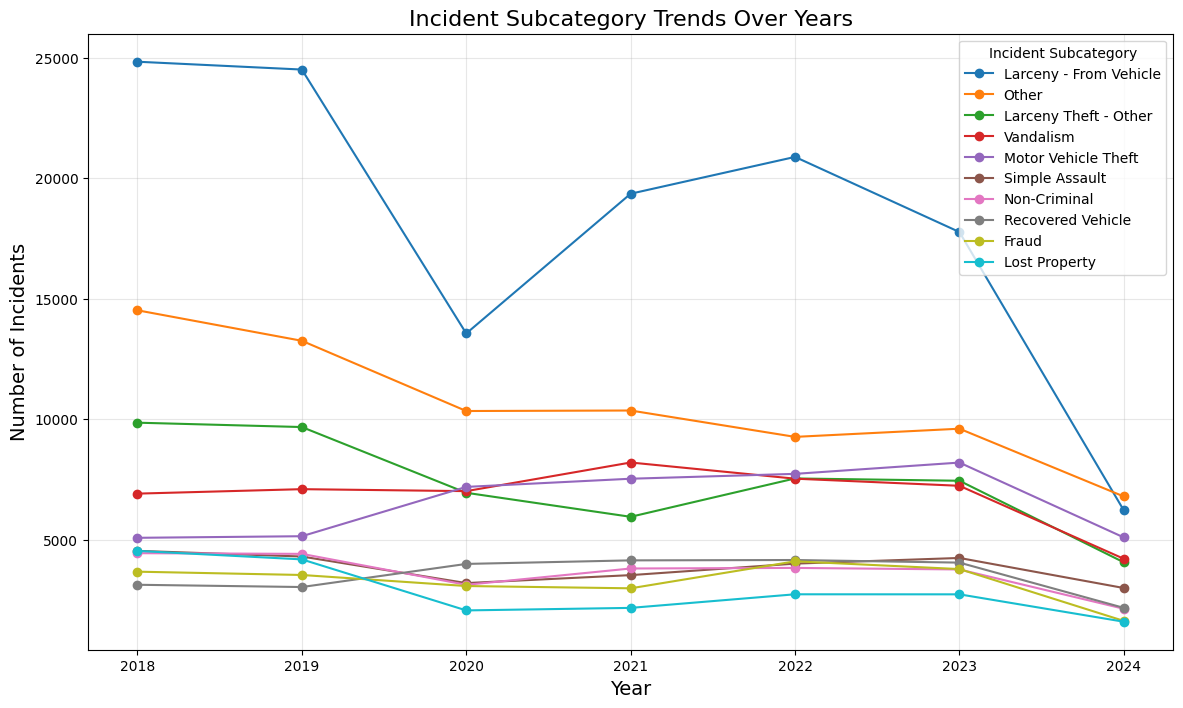

In [ ]:
cs5834_police_incidents_clean['Incident Datetime'] = pd.to_datetime(cs5834_police_incidents_clean['Incident Datetime'])
cs5834_police_incidents_clean['Year'] = cs5834_police_incidents_clean['Incident Datetime'].dt.year
cs5834_category_trends = cs5834_police_incidents_clean.groupby(['Year', 'Incident Subcategory']).size().reset_index(name='Count')

cs5834_top_categories = (
    cs5834_category_trends.groupby('Incident Subcategory')['Count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

cs5834_category_trends_top = cs5834_category_trends[cs5834_category_trends['Incident Subcategory'].isin(cs5834_top_categories)]

plt.figure(figsize=(14, 8))
for category in cs5834_top_categories:
    cs5834_data = cs5834_category_trends_top[cs5834_category_trends_top['Incident Subcategory'] == category]
    plt.plot(cs5834_data['Year'], cs5834_data['Count'], marker='o', label=category)

plt.title('Incident Subcategory Trends Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.legend(title='Incident Subcategory', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
cs5834_neighborhood_category = cs5834_police_incidents_clean.groupby(
    ['Analysis Neighborhood', 'Incident Category']
).size().reset_index(name='Crime Count')


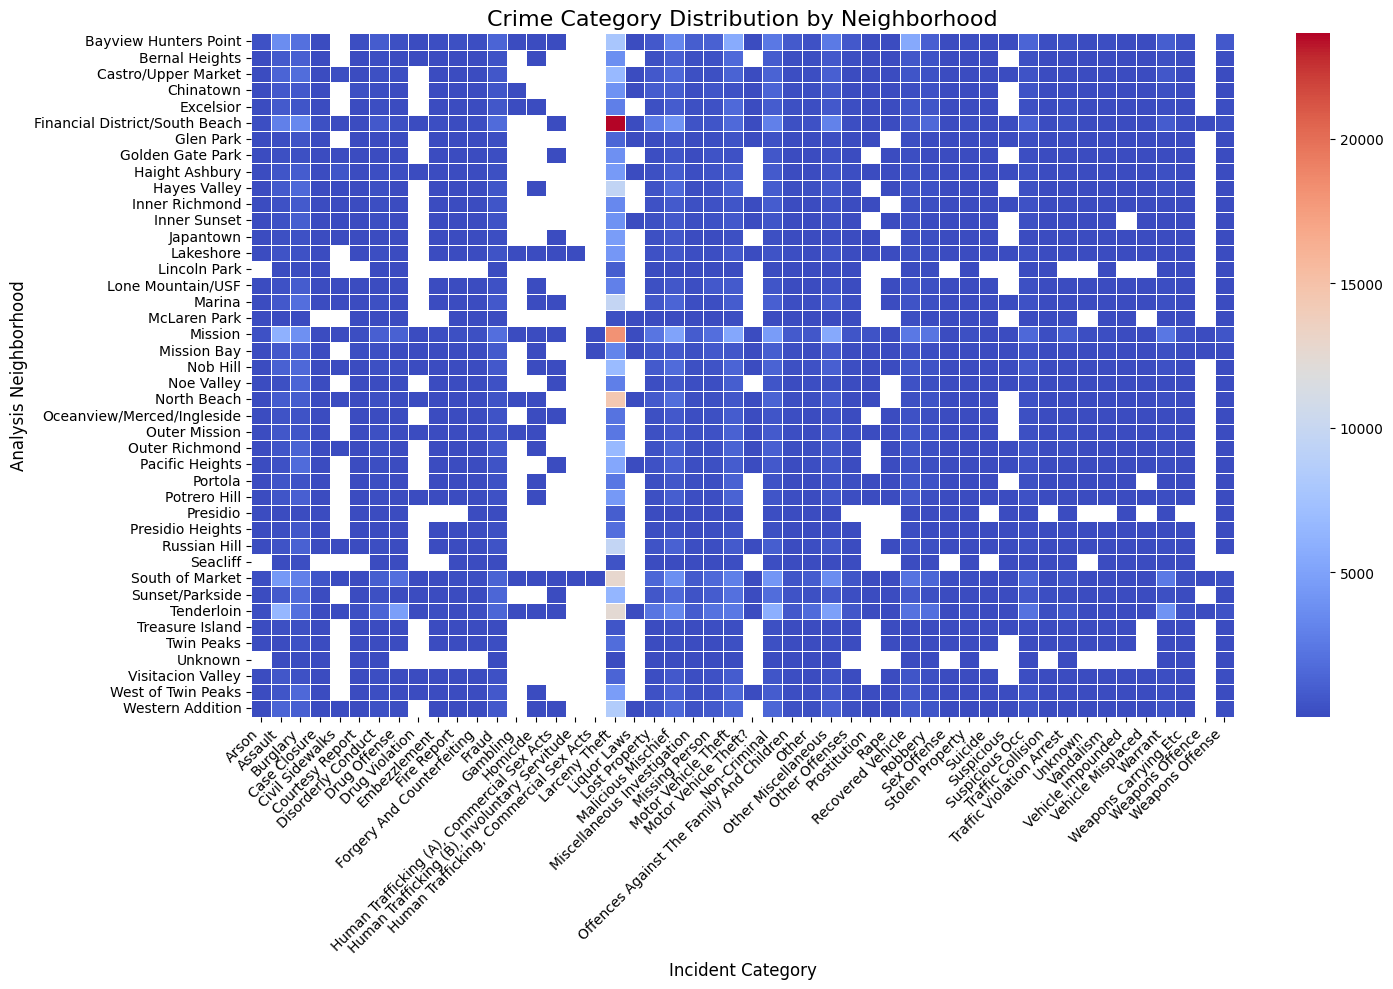

In [ ]:
cs5834_heatmap_data = cs5834_neighborhood_category.pivot(index='Analysis Neighborhood', columns='Incident Category', values='Crime Count')

plt.figure(figsize=(15, 10))
sns.heatmap(cs5834_heatmap_data, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Crime Category Distribution by Neighborhood', fontsize=16)
plt.xlabel('Incident Category', fontsize=12)
plt.ylabel('Analysis Neighborhood', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
def cs5834_highest_crime_neighborhoods(category):
    specific_category = cs5834_neighborhood_category[cs5834_neighborhood_category['Incident Category'] == category]
    return specific_category.nlargest(10, 'Crime Count')

cs5834_top_neighborhoods_larceny = cs5834_highest_crime_neighborhoods('Larceny Theft')
print("Top neighborhoods for Larceny Theft:")
print(cs5834_top_neighborhoods_larceny)

Top neighborhoods for Larceny Theft:
               Analysis Neighborhood Incident Category  Crime Count
228   Financial District/South Beach     Larceny Theft        23651
749                          Mission     Larceny Theft        18142
927                      North Beach     Larceny Theft        14468
1361                 South of Market     Larceny Theft        12781
1451                      Tenderloin     Larceny Theft        12445
670                           Marina     Larceny Theft         9766
1284                    Russian Hill     Larceny Theft         9667
397                     Hayes Valley     Larceny Theft         9544
1678                Western Addition     Larceny Theft         8493
15             Bayview Hunters Point     Larceny Theft         7799


#### Additional EDA on Crimes by Neighbourhood and Facilities Using Merged Dataset of Police Incidents and City Facilities

<ipython-input-28-ea911cef3e4e>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


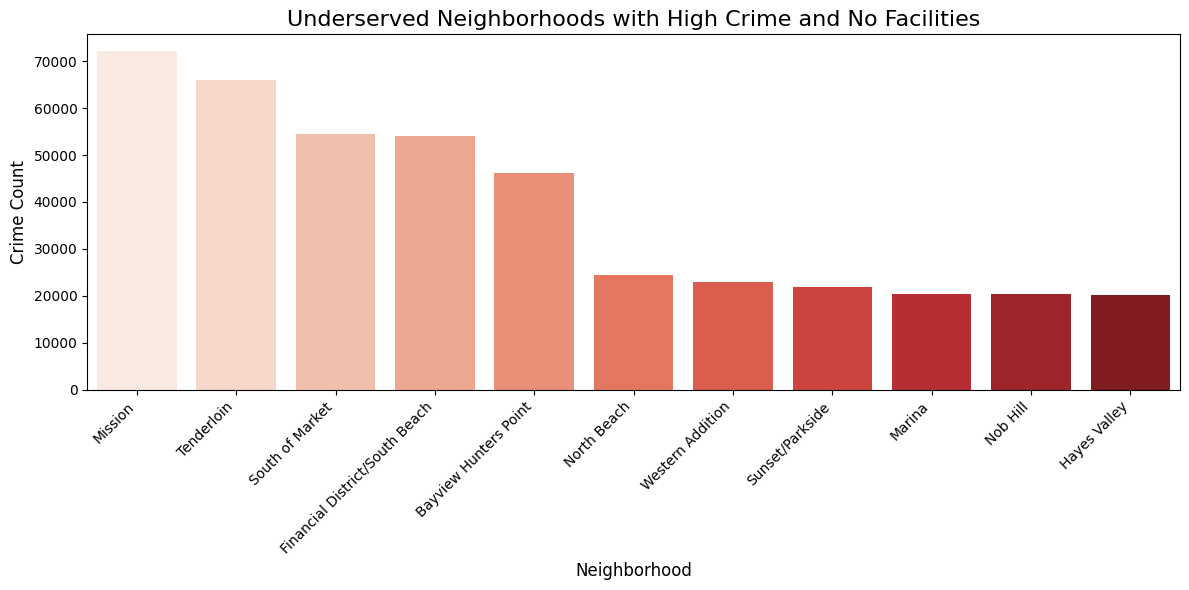

In [ ]:
cs5834_neighborhood_crime_count = cs5834_police_incidents_clean.groupby('Analysis Neighborhood').size().reset_index(name='Crime Count')
cs5834_facilities_per_neighborhood = cs5834_facilities_clean.groupby('supervisor_district').size().reset_index(name='Facility Count')

cs5834_neighborhood_analysis = cs5834_neighborhood_crime_count.merge(
    cs5834_facilities_per_neighborhood,
    left_on='Analysis Neighborhood',
    right_on='supervisor_district',
    how='left'
)
cs5834_neighborhood_analysis['Facility Count'] = cs5834_neighborhood_analysis['Facility Count'].fillna(0)

cs5834_neighborhood_analysis['Crime per Facility'] = np.where(
    cs5834_neighborhood_analysis['Facility Count'] > 0,
    cs5834_neighborhood_analysis['Crime Count'] / cs5834_neighborhood_analysis['Facility Count'],
    np.nan
)

cs5834_high_crime_threshold = cs5834_neighborhood_analysis['Crime Count'].quantile(0.75)
cs5834_underserved_neighborhoods = cs5834_neighborhood_analysis[
    (cs5834_neighborhood_analysis['Crime Count'] > cs5834_high_crime_threshold) & (cs5834_neighborhood_analysis['Facility Count'] == 0)
]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=cs5834_underserved_neighborhoods.sort_values('Crime Count', ascending=False),
    x='Analysis Neighborhood',
    y='Crime Count',
    palette='Reds'
)
plt.title('Underserved Neighborhoods with High Crime and No Facilities', fontsize=16)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Crime Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("Underserved Neighborhoods with High Crime and No Facilities:")
print(cs5834_underserved_neighborhoods[['Analysis Neighborhood', 'Crime Count', 'Facility Count']])

Underserved Neighborhoods with High Crime and No Facilities:
             Analysis Neighborhood  Crime Count  Facility Count
0            Bayview Hunters Point        46148             0.0
5   Financial District/South Beach        54076             0.0
9                     Hayes Valley        20184             0.0
16                          Marina        20334             0.0
18                         Mission        72084             0.0
20                        Nob Hill        20324             0.0
22                     North Beach        24436             0.0
33                 South of Market        54481             0.0
34                 Sunset/Parkside        21942             0.0
35                      Tenderloin        65943             0.0
41                Western Addition        22956             0.0


<ipython-input-13-bd66fab26f4e>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cs5834_top_facilities, x='Crime Count', y='Facility', palette='viridis')


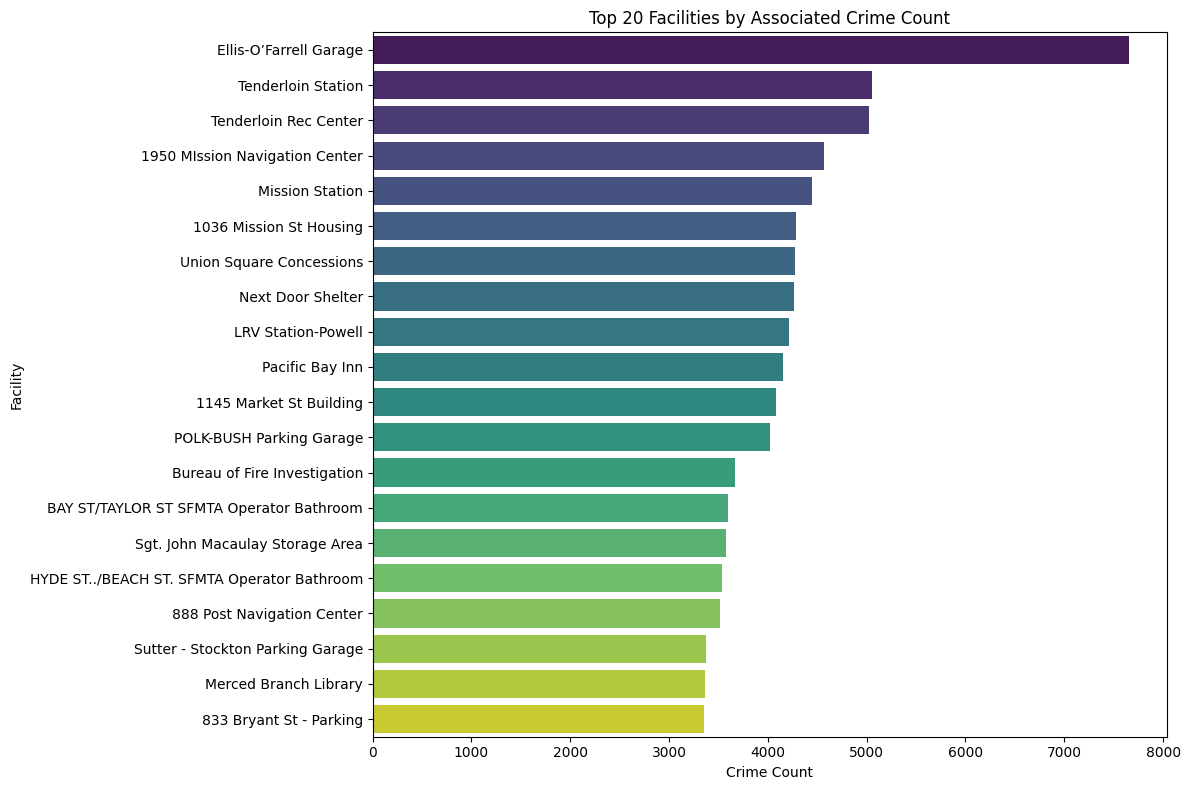

In [ ]:
assert 'Latitude' in cs5834_police_incidents_clean.columns, "Latitude column missing"
assert 'Longitude' in cs5834_police_incidents_clean.columns, "Longitude column missing"
assert 'latitude' in cs5834_facilities_clean.columns, "Facility latitude column missing"
assert 'longitude' in cs5834_facilities_clean.columns, "Facility longitude column missing"

cs5834_crime_coords = np.array(cs5834_police_incidents_clean[['Latitude', 'Longitude']])
cs5834_facility_coords = np.array(cs5834_facilities_clean[['latitude', 'longitude']])
cs5834_tree = cKDTree(cs5834_facility_coords)
cs5834_distances, cs5834_indices = cs5834_tree.query(cs5834_crime_coords, k=1)

cs5834_police_incidents_clean['Nearest Facility'] = cs5834_facilities_clean.iloc[cs5834_indices]['common_name'].values
cs5834_police_incidents_clean['Distance to Facility'] = cs5834_distances
cs5834_crime_by_facility = cs5834_police_incidents_clean.groupby('Nearest Facility')['Incident Category'].count().reset_index()
cs5834_crime_by_facility.columns = ['Facility', 'Crime Count']

plt.figure(figsize=(12, 8))
cs5834_top_facilities = cs5834_crime_by_facility.sort_values(by='Crime Count', ascending=False).head(20)
sns.barplot(data=cs5834_top_facilities, x='Crime Count', y='Facility', palette='viridis')
plt.title("Top 20 Facilities by Associated Crime Count")
plt.xlabel("Crime Count")
plt.ylabel("Facility")
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

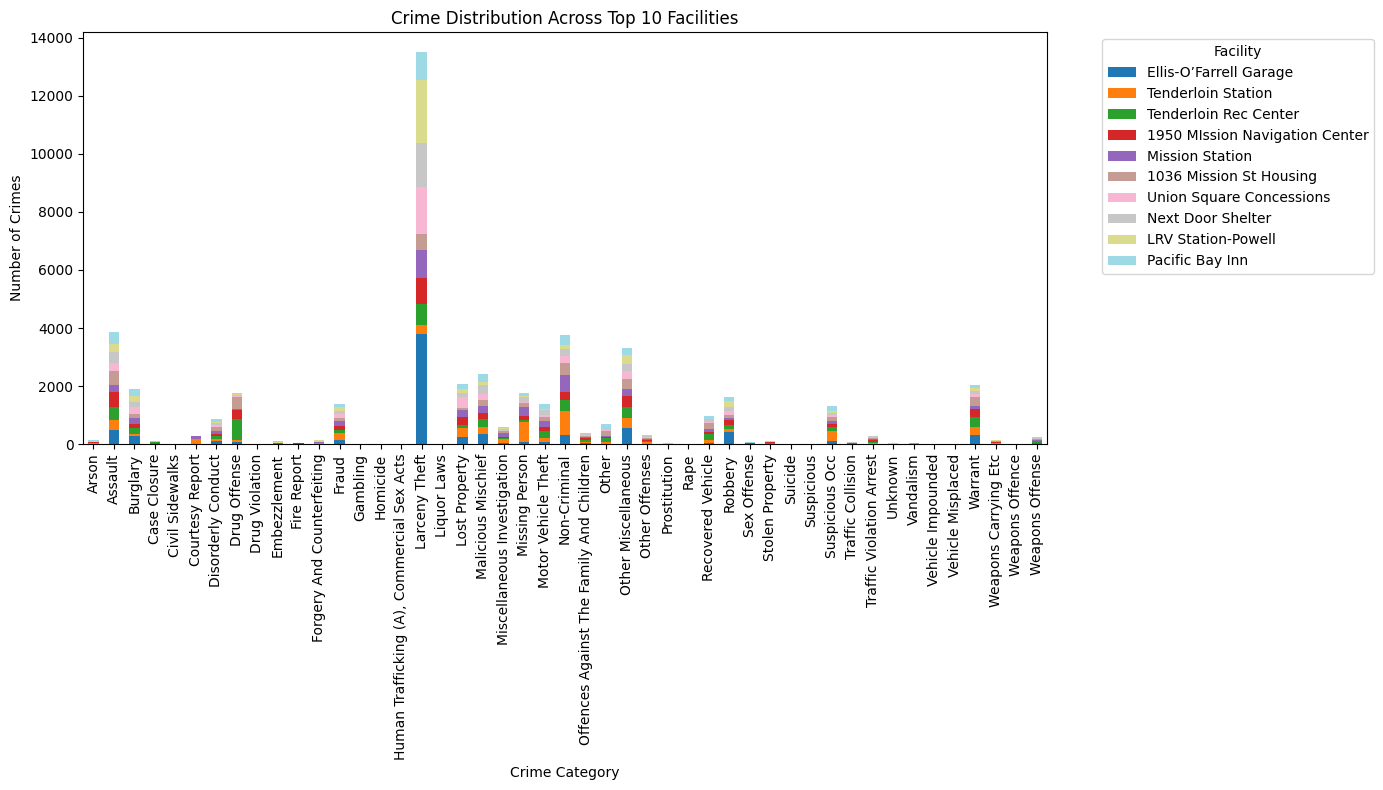

In [ ]:
cs5834_top_10_facilities = cs5834_crime_by_facility.sort_values(by="Crime Count", ascending=False).head(10)
cs5834_filtered_incidents = cs5834_police_incidents_clean[
    cs5834_police_incidents_clean["Nearest Facility"].isin(cs5834_top_10_facilities["Facility"])
]
cs5834_crime_distribution = (
    cs5834_filtered_incidents.groupby(["Nearest Facility", "Incident Category"])
    .size()
    .reset_index(name="Crime Count")
)

cs5834_crime_pivot = cs5834_crime_distribution.pivot(
    index="Incident Category", columns="Nearest Facility", values="Crime Count"
).fillna(0)

plt.figure(figsize=(12, 8))
cs5834_crime_pivot[cs5834_top_10_facilities["Facility"]].plot(
    kind="bar", stacked=True, figsize=(14, 8), colormap="tab20"
)
plt.title("Crime Distribution Across Top 10 Facilities")
plt.ylabel("Number of Crimes")
plt.xlabel("Crime Category")
plt.legend(title="Facility", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Exploratory Data Analysis on Car Breakins Using Police Incidents Dataset and Facilities Dataset

#### Creating the subset of Carbreak in data

In [ ]:
cs5834_relevant_crimes = ['Theft, From Locked Vehicle, >$950', 'Theft, From Locked Vehicle, $200-$950']
cs5834_subset_data = cs5834_police_incidents_clean[
    cs5834_police_incidents_clean['Incident Description'].isin(cs5834_relevant_crimes)
]
cs5834_subset_columns = [
    'Incident Datetime', 'Incident Category', 'Incident Subcategory',
    'Latitude', 'Longitude', 'Police District', 'Analysis Neighborhood', 'Incident Description'
]
cs5834_subset_data = cs5834_subset_data[cs5834_subset_columns]

print(f"Subset shape: {cs5834_subset_data.shape}")
print("-----------------------------------------------------------------------------")
print(cs5834_subset_data.head())
print("-----------------------------------------------------------------------------")
print(cs5834_subset_data['Incident Subcategory'].value_counts())


Subset shape: (102104, 8)
       Incident Datetime Incident Category    Incident Subcategory   Latitude  \
1156 2022-03-21 18:00:00     Larceny Theft  Larceny - From Vehicle  37.786196   
1744 2022-07-20 10:00:00     Larceny Theft  Larceny - From Vehicle  37.768178   
1835 2023-09-23 19:40:00     Larceny Theft  Larceny - From Vehicle  37.780576   
1851 2023-09-28 20:45:00     Larceny Theft  Larceny - From Vehicle  37.794527   
1875 2023-09-29 11:15:00     Larceny Theft  Larceny - From Vehicle  37.786868   

       Longitude Police District Analysis Neighborhood  \
1156 -122.424858        Northern             Japantown   
1744 -122.410731         Mission               Mission   
1835 -122.420255        Northern            Tenderloin   
1851 -122.411364         Central              Nob Hill   
1875 -122.423308        Northern      Western Addition   

                       Incident Description  
1156      Theft, From Locked Vehicle, >$950  
1744      Theft, From Locked Vehicle, >$950  


In [ ]:
cs5834_car_breakins = pd.read_csv("Carbreakins.csv")
cs5834_facilities = pd.read_csv("facilities.csv")
print("Car Break-Ins Dataset Info:")
print(cs5834_car_breakins.info())
print("\nFacilities Dataset Info:")
print(cs5834_facilities.info())

Car Break-Ins Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102104 entries, 0 to 102103
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Incident Datetime      102104 non-null  object 
 1   Incident Category      102104 non-null  object 
 2   Incident Subcategory   102104 non-null  object 
 3   Latitude               102104 non-null  float64
 4   Longitude              102104 non-null  float64
 5   Police District        102104 non-null  object 
 6   Analysis Neighborhood  102104 non-null  object 
 7   Incident Description   102104 non-null  object 
dtypes: float64(2), object(6)
memory usage: 6.2+ MB
None

Facilities Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   facility_id               1

#### Cleaning the Carbreak-ins dataset for removing duplicates

In [ ]:
cs5834_car_breakins = cs5834_car_breakins.drop_duplicates()
cs5834_facilities = cs5834_facilities.drop_duplicates()
print("\nMissing Values in Car Break-Ins Dataset:")
print(cs5834_car_breakins.isnull().sum())
print("\nMissing Values in Facilities Dataset:")
print(cs5834_facilities.isnull().sum())


Missing Values in Car Break-Ins Dataset:
Incident Datetime        0
Incident Category        0
Incident Subcategory     0
Latitude                 0
Longitude                0
Police District          0
Analysis Neighborhood    0
Incident Description     0
dtype: int64

Missing Values in Facilities Dataset:
facility_id                 0
common_name                 0
address                     0
city                        0
zip_code                    0
owned_leased                0
dept_id_for_jurisdiction    0
jurisdiction                0
longitude                   0
latitude                    0
supervisor_district         0
dtype: int64


In [ ]:
cs5834_car_breakins = cs5834_car_breakins[
    ['Incident Datetime', 'Latitude', 'Longitude', 'Analysis Neighborhood', 'Incident Subcategory', 'Incident Description']
]
cs5834_facilities = cs5834_facilities[['facility_id', 'common_name', 'latitude', 'longitude', 'jurisdiction']]
cs5834_car_breakins = cs5834_car_breakins.dropna(subset=['Latitude', 'Longitude'])
cs5834_facilities = cs5834_facilities.dropna(subset=['latitude', 'longitude'])

print(cs5834_car_breakins.shape)
print(cs5834_facilities.shape)

(97261, 6)
(1729, 5)


In [36]:
def cs5834_find_nearest_facility(cs5834_car_breakins, cs5834_facilities):
    facilities_coords = cs5834_facilities[['latitude', 'longitude']].to_numpy()
    car_coords = cs5834_car_breakins[['Latitude', 'Longitude']].to_numpy()

    facility_tree = KDTree(facilities_coords)
    distances, indices = facility_tree.query(car_coords)
    cs5834_car_breakins['Nearest Facility ID'] = indices
    cs5834_car_breakins['Distance to Facility (meters)'] = distances
    nearest_facilities = cs5834_facilities.iloc[indices].reset_index(drop=True)
    cs5834_car_breakins = pd.concat([cs5834_car_breakins.reset_index(drop=True), nearest_facilities], axis=1)
    return cs5834_car_breakins

<ipython-input-37-44d1fd7672ad>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cs5834_top_facilities, y='common_name', x='Crime Count', palette='coolwarm')


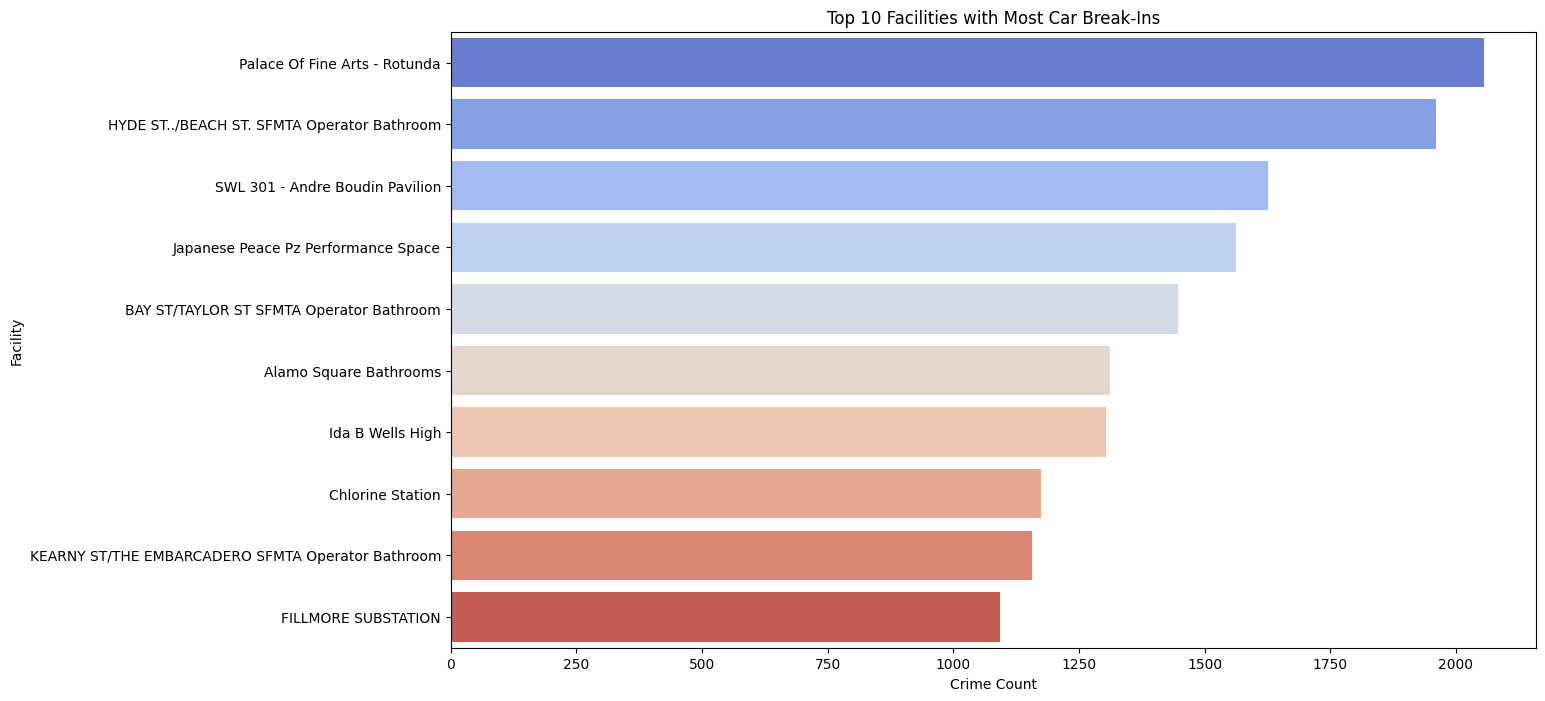

In [37]:
from scipy.spatial import KDTree
cs5834_car_breakins = cs5834_find_nearest_facility(cs5834_car_breakins, cs5834_facilities)
cs5834_facility_crime_count = cs5834_car_breakins.groupby('common_name').size().reset_index(name='Crime Count')
cs5834_neighborhood_crime_count = cs5834_car_breakins.groupby('Analysis Neighborhood').size().reset_index(name='Crime Count')
plt.figure(figsize=(14, 8))
cs5834_top_facilities = cs5834_facility_crime_count.sort_values(by='Crime Count', ascending=False).head(10)
sns.barplot(data=cs5834_top_facilities, y='common_name', x='Crime Count', palette='coolwarm')
plt.title('Top 10 Facilities with Most Car Break-Ins')
plt.xlabel('Crime Count')
plt.ylabel('Facility')
plt.show()

<ipython-input-38-ad9899a6ed49>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cs5834_top_neighborhoods, y='Analysis Neighborhood', x='Crime Count', palette='coolwarm')


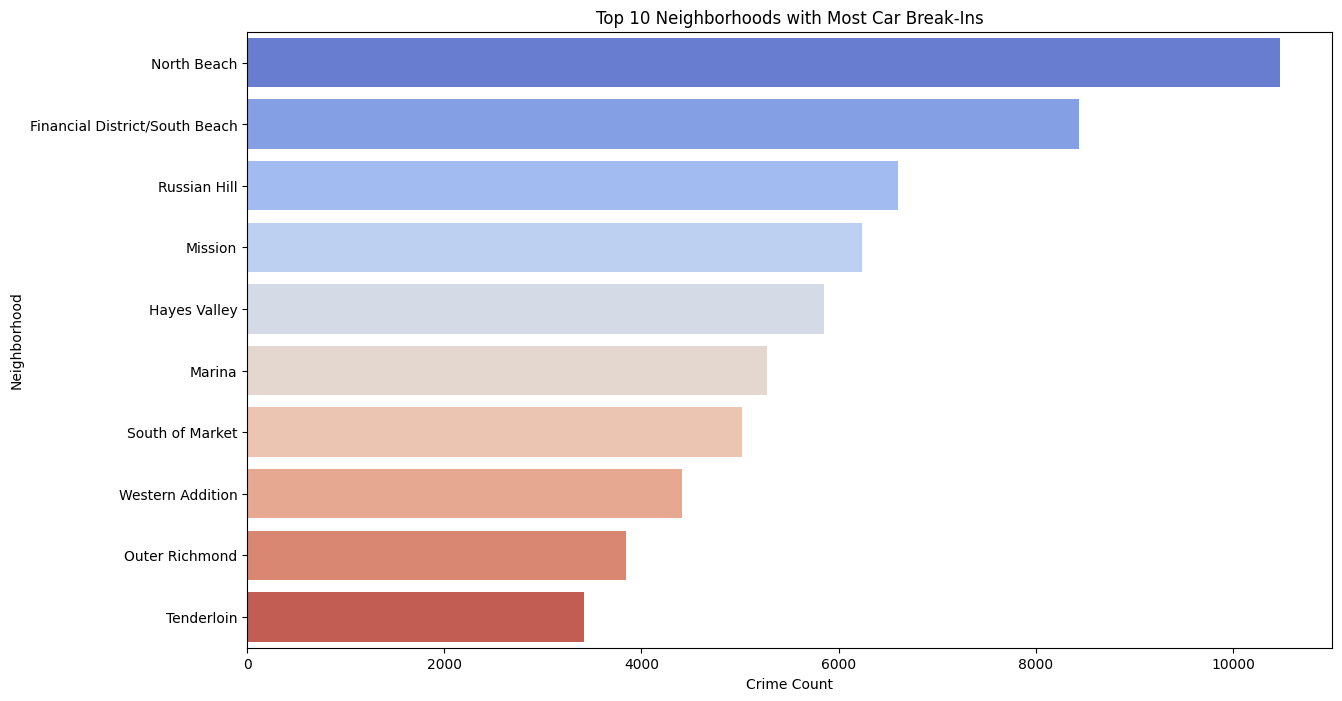

In [38]:
plt.figure(figsize=(14, 8))
cs5834_neighborhood_crime_count = cs5834_car_breakins.groupby('Analysis Neighborhood').size().reset_index(name='Crime Count')
cs5834_top_neighborhoods = cs5834_neighborhood_crime_count.sort_values(by='Crime Count', ascending=False).head(10)
sns.barplot(data=cs5834_top_neighborhoods, y='Analysis Neighborhood', x='Crime Count', palette='coolwarm')
plt.title('Top 10 Neighborhoods with Most Car Break-Ins')
plt.xlabel('Crime Count')
plt.ylabel('Neighborhood')
plt.show()

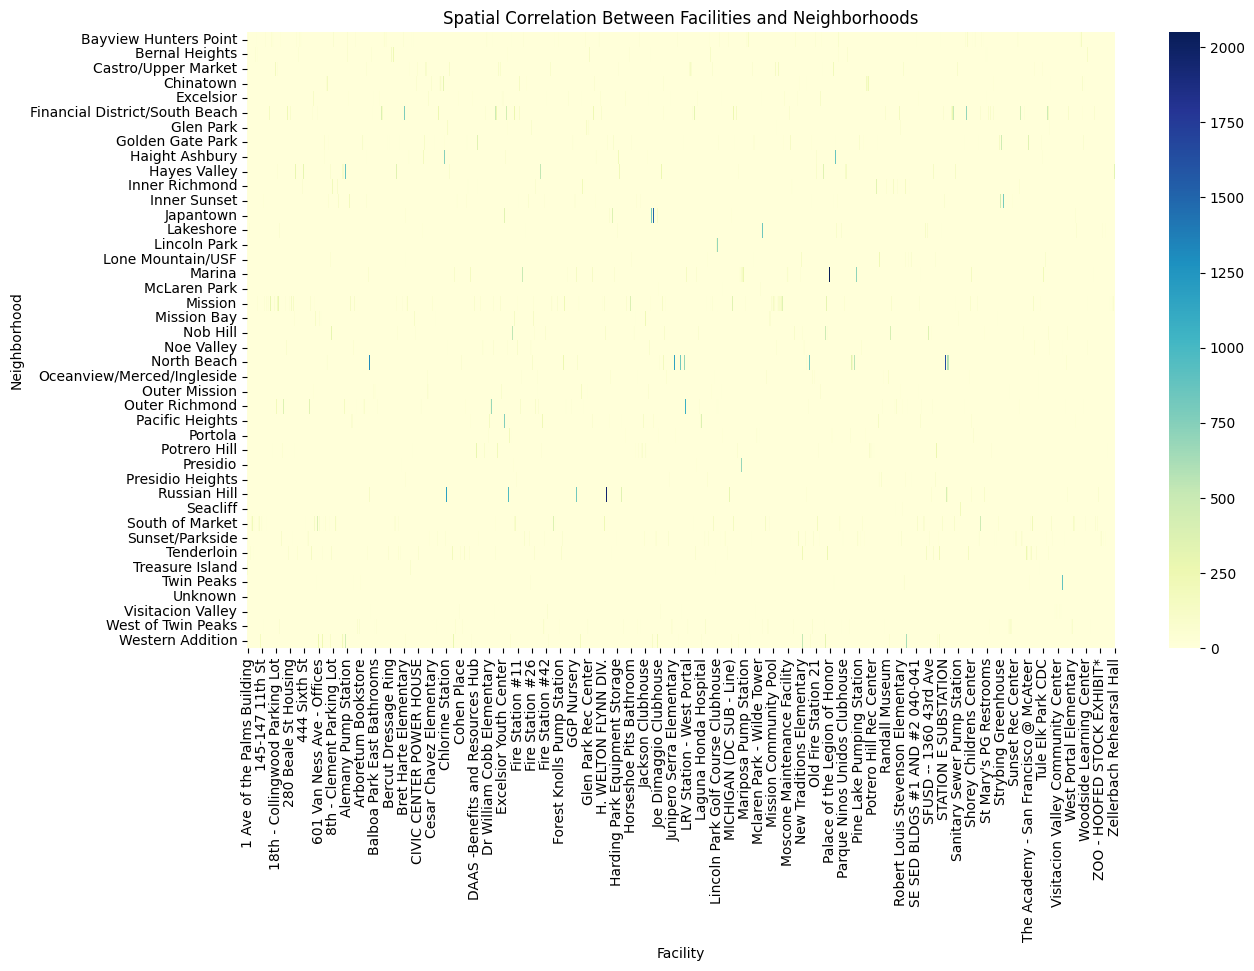

In [39]:
cs5834_spatial_correlation = cs5834_car_breakins.groupby(['Analysis Neighborhood', 'common_name']).size().reset_index(name='Crime Count')
plt.figure(figsize=(14, 8))
sns.heatmap(cs5834_spatial_correlation.pivot(index='Analysis Neighborhood', columns='common_name', values='Crime Count').fillna(0), cmap='YlGnBu')
plt.title('Spatial Correlation Between Facilities and Neighborhoods')
plt.xlabel('Facility')
plt.ylabel('Neighborhood')
plt.show()

#### Performing EDA For Temporal Analysis on Car Breakins Dataset

<ipython-input-40-88175ae1522c>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cs5834_car_breakins['Incident Datetime'] = pd.to_datetime(cs5834_car_breakins['Incident Datetime'])
<ipython-input-40-88175ae1522c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cs5834_day_counts.index, y=cs5834_day_counts.values, palette='coolwarm')


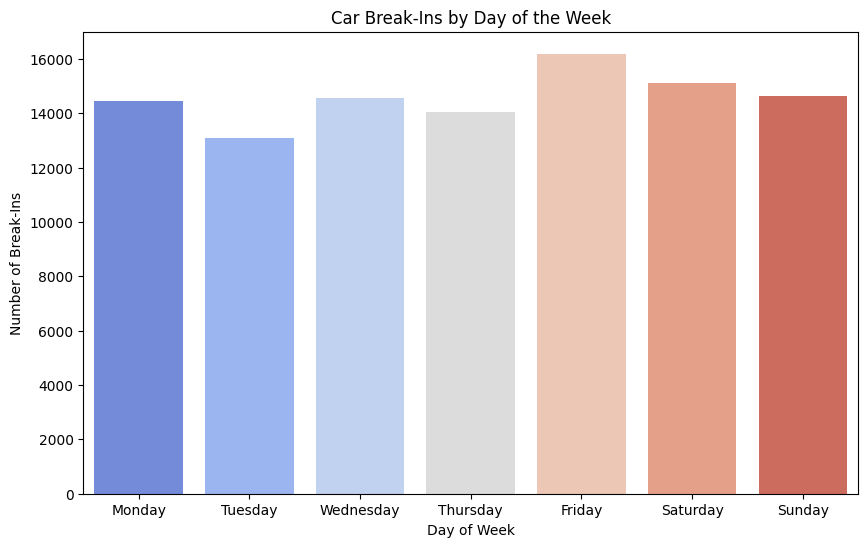

In [40]:
cs5834_car_breakins = cs5834_car_breakins.dropna(subset=['Latitude', 'Longitude'])
cs5834_facilities = cs5834_facilities.dropna(subset=['latitude', 'longitude'])
cs5834_car_breakins['Incident Datetime'] = pd.to_datetime(cs5834_car_breakins['Incident Datetime'])
cs5834_car_breakins['Day of Week'] = cs5834_car_breakins['Incident Datetime'].dt.day_name()
cs5834_car_breakins['Hour'] = cs5834_car_breakins['Incident Datetime'].dt.hour
cs5834_car_breakins['Month'] = cs5834_car_breakins['Incident Datetime'].dt.month
plt.figure(figsize=(10, 6))
cs5834_day_counts = cs5834_car_breakins['Day of Week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
sns.barplot(x=cs5834_day_counts.index, y=cs5834_day_counts.values, palette='coolwarm')
plt.title("Car Break-Ins by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Break-Ins")
plt.show()

<ipython-input-41-48f9a0ba8e6b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cs5834_hour_counts.index, y=cs5834_hour_counts.values, palette='viridis')


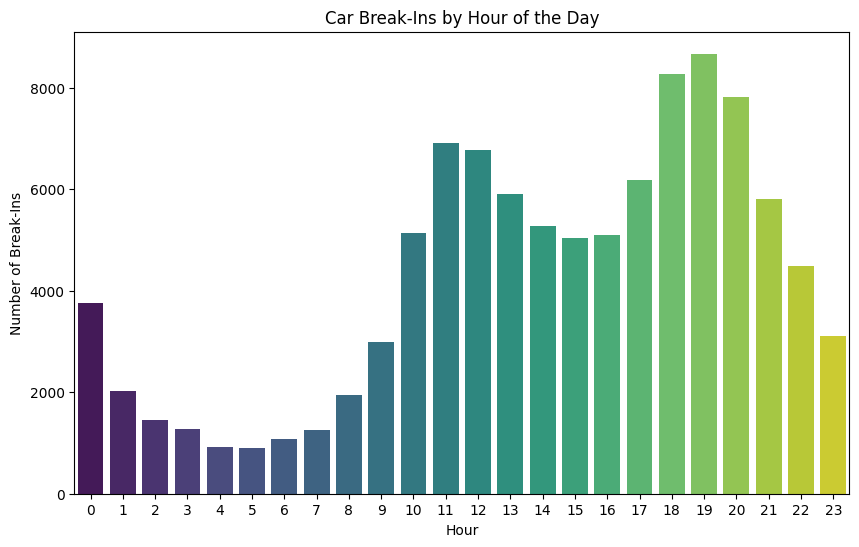

In [41]:
plt.figure(figsize=(10, 6))
cs5834_hour_counts = cs5834_car_breakins['Hour'].value_counts().sort_index()
sns.barplot(x=cs5834_hour_counts.index, y=cs5834_hour_counts.values, palette='viridis')
plt.title("Car Break-Ins by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Number of Break-Ins")
plt.show()

<ipython-input-42-ae5fdea56d9f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cs5834_month_counts.index, y=cs5834_month_counts.values, palette='magma')


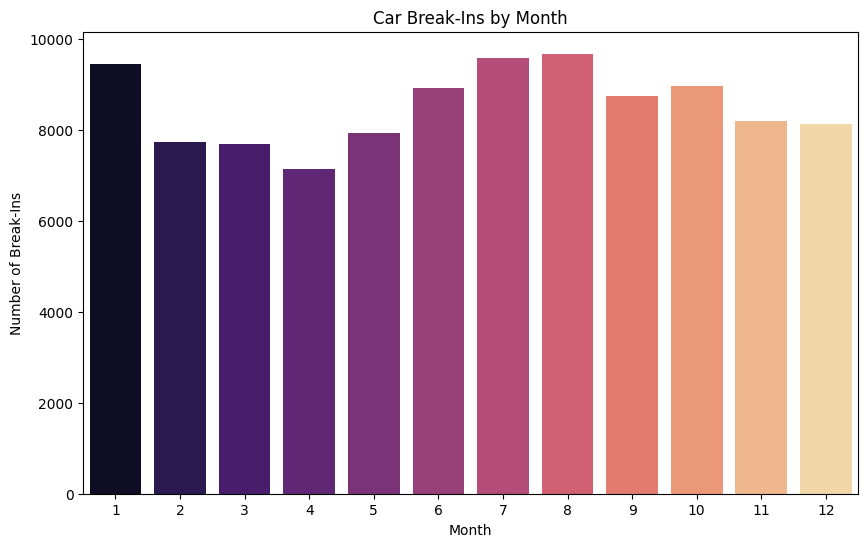

In [42]:
plt.figure(figsize=(10, 6))
cs5834_month_counts = cs5834_car_breakins['Month'].value_counts().sort_index()
sns.barplot(x=cs5834_month_counts.index, y=cs5834_month_counts.values, palette='magma')
plt.title("Car Break-Ins by Month")
plt.xlabel("Month")
plt.ylabel("Number of Break-Ins")
plt.show()

In [43]:
cs5834_hotspot_map = folium.Map(location=[cs5834_car_breakins['Latitude'].mean(), cs5834_car_breakins['Longitude'].mean()], zoom_start=12)
for _, row in cs5834_car_breakins.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(cs5834_hotspot_map)

cs5834_hotspot_map.save("cs5834_car_breakins_hotspots.html")



In [44]:
cs5834_facilities_coords = cs5834_facilities[['latitude', 'longitude']].to_numpy()
cs5834_car_coords = cs5834_car_breakins[['Latitude', 'Longitude']].to_numpy()
cs5834_facility_tree = KDTree(cs5834_facilities_coords)
cs5834_distances, cs5834_indices = cs5834_facility_tree.query(cs5834_car_coords)
cs5834_car_breakins['Nearest Facility ID'] = cs5834_indices
cs5834_car_breakins['Distance to Facility (meters)'] = cs5834_distances
cs5834_nearest_facilities = cs5834_facilities.iloc[cs5834_indices].reset_index(drop=True)
cs5834_car_breakins = pd.concat([cs5834_car_breakins.reset_index(drop=True), cs5834_nearest_facilities], axis=1)

In [45]:
cs5834_car_breakins.head()

,Incident Datetime,Incident Category,Incident Subcategory,Latitude,Longitude,Police District,Analysis Neighborhood,Incident Description,Nearest Facility ID,Distance to Facility (meters),...,common_name,address,city,zip_code,owned_leased,dept_id_for_jurisdiction,jurisdiction,longitude,latitude,supervisor_district
0,2022-03-21 18:00:00,Larceny Theft,Larceny - From Vehicle,37.786196,-122.424858,Northern,Japantown,"Theft, From Locked Vehicle, >$950",622,0.004691,...,Jefferson Square Bathrooms,997 Gough St,San Francisco,94109,Own,49,Recreation And Parks,-122.425490,37.781548,5.0
1,2022-07-20 10:00:00,Larceny Theft,Larceny - From Vehicle,37.768178,-122.410731,Mission,Mission,"Theft, From Locked Vehicle, >$950",314,0.000428,...,Animal Care and Control Facility,1419 Bryant St,San Francisco,94103,Own,63,Gsa - Real Estate Division,-122.410534,37.768557,9.0
2,2023-09-23 19:40:00,Larceny Theft,Larceny - From Vehicle,37.780576,-122.420255,Northern,Tenderloin,"Theft, From Locked Vehicle, $200-$950",45,0.000612,...,Civic Center Courthouse,400 McAllister St,San Francisco,94102,Own,4,Superior Court,-122.419660,37.780436,5.0
3,2023-09-28 20:45:00,Larceny Theft,Larceny - From Vehicle,37.794527,-122.411364,Central,Nob Hill,"Theft, From Locked Vehicle, >$950",80,0.000528,...,Betty Ong Rec Center,1199 Mason St,San Francisco,94108,Own,49,Recreation And Parks,-122.411786,37.794209,3.0
4,2023-09-29 11:15:00,Larceny Theft,Larceny - From Vehicle,37.786868,-122.423308,Northern,Western Addition,"Theft, From Locked Vehicle, $200-$950",633,0.003345,...,Next Door Shelter,1001 Polk St,San Francisco,94109,Own,45,Police Department,-122.420049,37.786116,3.0


In [46]:
cs5834_car_breakins = cs5834_car_breakins.loc[:, ~cs5834_car_breakins.columns.duplicated()]
print(cs5834_car_breakins.columns)

Index(['Incident Datetime', 'Incident Category', 'Incident Subcategory',
       'Latitude', 'Longitude', 'Police District', 'Analysis Neighborhood',
       'Incident Description', 'Nearest Facility ID',
       'Distance to Facility (meters)', 'facility_id', 'common_name',
       'address', 'city', 'zip_code', 'owned_leased',
       'dept_id_for_jurisdiction', 'jurisdiction', 'longitude', 'latitude',
       'supervisor_district', 'Day of Week', 'Hour', 'Month'],
      dtype='object')


<ipython-input-47-ac1ab7d79100>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cs5834_top_descriptions, x='Crime Count', y='Incident Description', palette='crest')


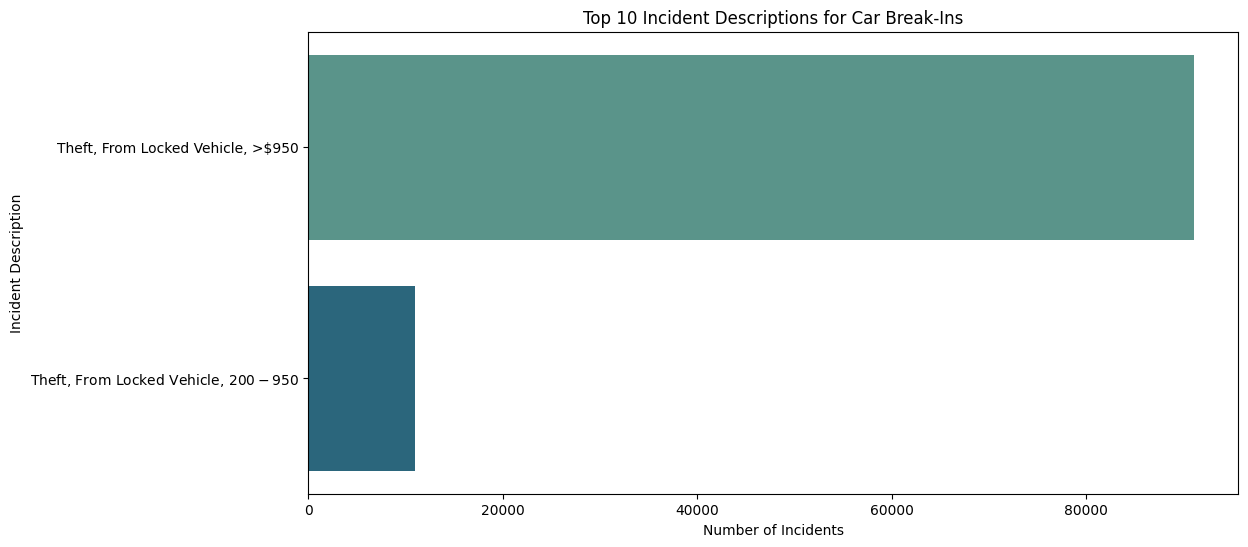

In [47]:
cs5834_description_severity = cs5834_car_breakins.groupby('Incident Description').size().reset_index(name='Crime Count')
plt.figure(figsize=(12, 6))
cs5834_top_descriptions = cs5834_description_severity.sort_values(by='Crime Count', ascending=False).head(10)
sns.barplot(data=cs5834_top_descriptions, x='Crime Count', y='Incident Description', palette='crest')
plt.title('Top 10 Incident Descriptions for Car Break-Ins')
plt.xlabel('Number of Incidents')
plt.ylabel('Incident Description')
plt.show()

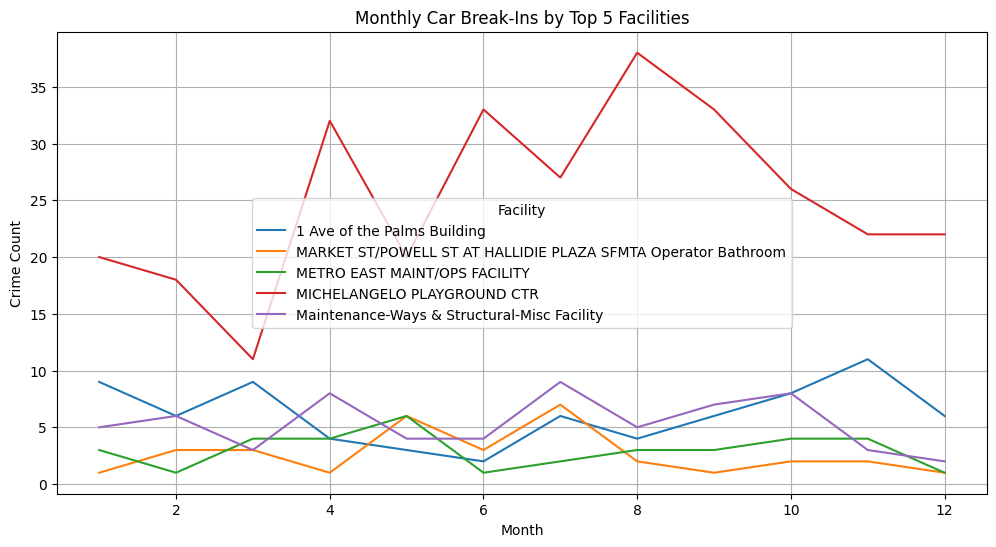

In [48]:
cs5834_facility_temporal_trends = cs5834_car_breakins.groupby(['common_name', 'Month']).size().reset_index(name='Crime Count')
cs5834_top_facilities = cs5834_facility_temporal_trends['common_name'].value_counts().head(5).index
cs5834_filtered_trends = cs5834_facility_temporal_trends[cs5834_facility_temporal_trends['common_name'].isin(cs5834_top_facilities)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=cs5834_filtered_trends, x='Month', y='Crime Count', hue='common_name', palette='tab10')
plt.title('Monthly Car Break-Ins by Top 5 Facilities')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.legend(title='Facility')
plt.grid(True)
plt.show()

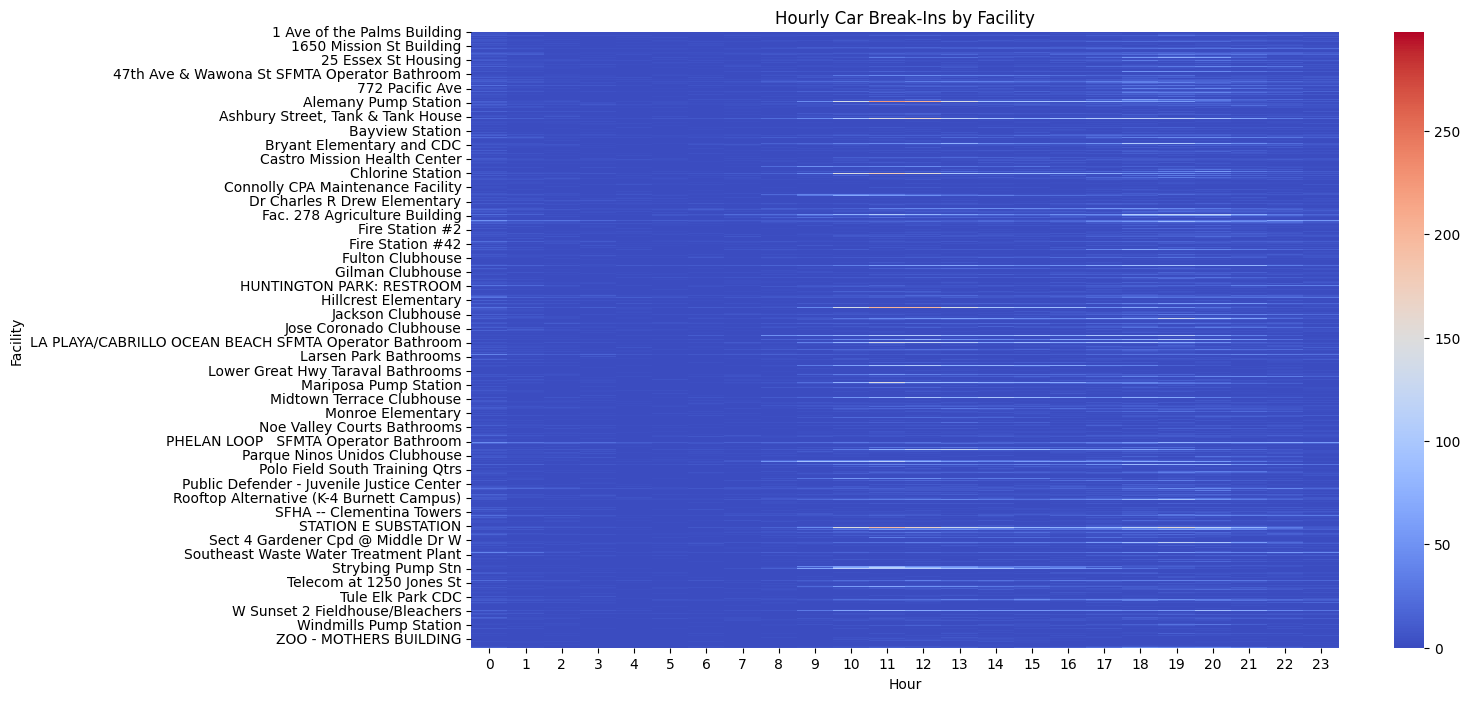

In [49]:
cs5834_hourly_heatmap = cs5834_car_breakins.groupby(['common_name', 'Hour']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(cs5834_hourly_heatmap, cmap='coolwarm', annot=False, cbar=True)
plt.title('Hourly Car Break-Ins by Facility')
plt.xlabel('Hour')
plt.ylabel('Facility')
plt.show()

Pearson Correlation: -0.04, p-value: 0.2120
Spearman Correlation: 0.08, p-value: 0.0215


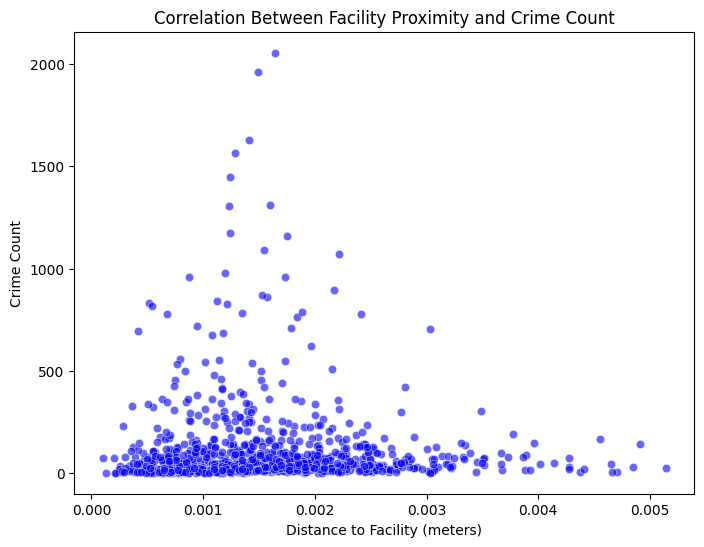

In [50]:
from scipy.stats import pearsonr, spearmanr
cs5834_correlation_data = cs5834_car_breakins.groupby('Nearest Facility ID').agg({
    'Distance to Facility (meters)': 'mean',
    'Incident Subcategory': 'count'
}).reset_index()
cs5834_correlation_data.rename(columns={'Incident Subcategory': 'Crime Count'}, inplace=True)
cs5834_pearson_corr, cs5834_pearson_p = pearsonr(cs5834_correlation_data['Distance to Facility (meters)'], cs5834_correlation_data['Crime Count'])
print(f"Pearson Correlation: {cs5834_pearson_corr:.2f}, p-value: {cs5834_pearson_p:.4f}")
cs5834_spearman_corr, cs5834_spearman_p = spearmanr(cs5834_correlation_data['Distance to Facility (meters)'], cs5834_correlation_data['Crime Count'])
print(f"Spearman Correlation: {cs5834_spearman_corr:.2f}, p-value: {cs5834_spearman_p:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cs5834_correlation_data, x='Distance to Facility (meters)', y='Crime Count', alpha=0.6, color='b')
plt.title('Correlation Between Facility Proximity and Crime Count')
plt.xlabel('Distance to Facility (meters)')
plt.ylabel('Crime Count')
plt.show()


In [51]:
cs5834_facility_neighborhood_counts = cs5834_car_breakins.groupby(['common_name', 'Analysis Neighborhood']).size().reset_index(name='Break-In Count')

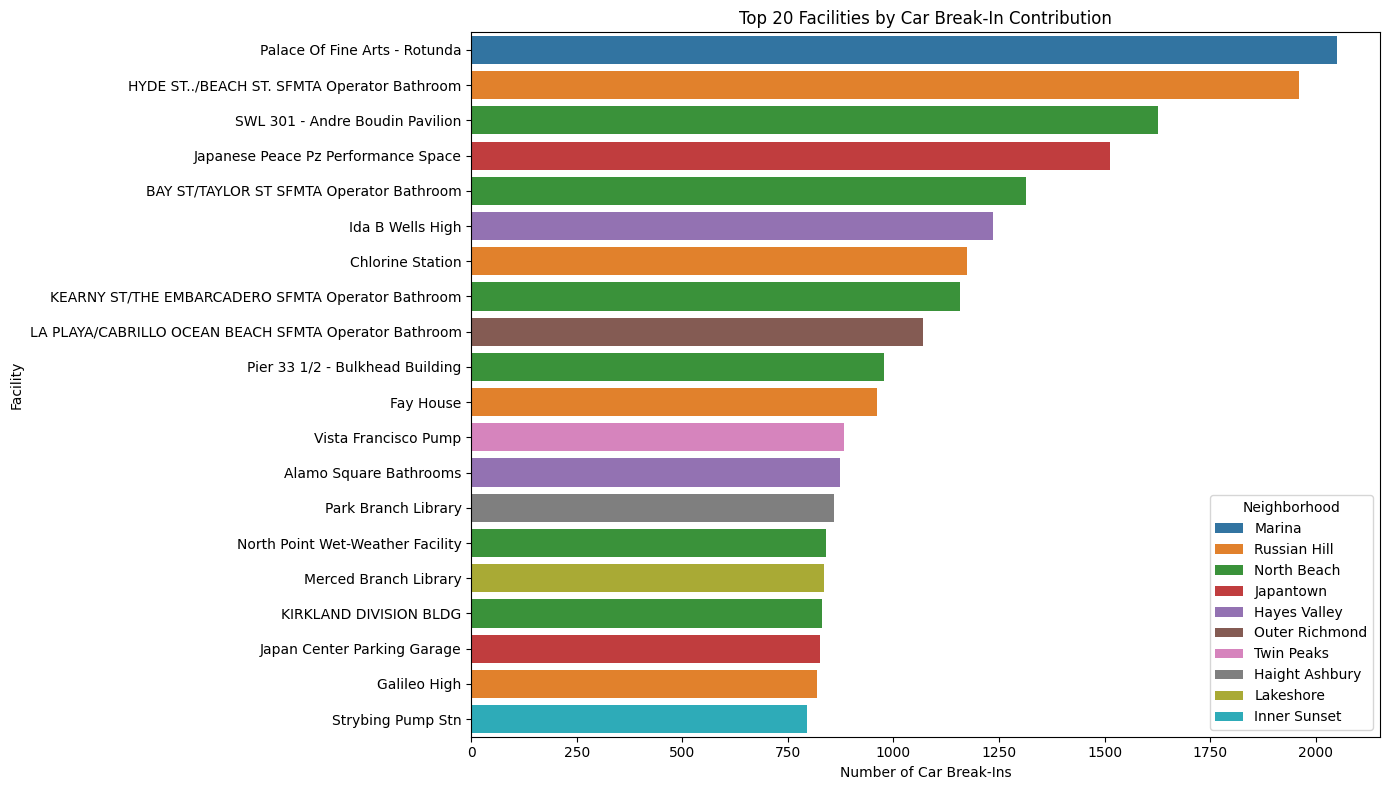

In [52]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=cs5834_facility_neighborhood_counts.sort_values('Break-In Count', ascending=False).head(20),
    x='Break-In Count',
    y='common_name',
    hue='Analysis Neighborhood',
    dodge=False
)
plt.title("Top 20 Facilities by Car Break-In Contribution")
plt.xlabel("Number of Car Break-Ins")
plt.ylabel("Facility")
plt.legend(title="Neighborhood", loc='lower right')
plt.tight_layout()
plt.show()

<ipython-input-53-47fdc739738b>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


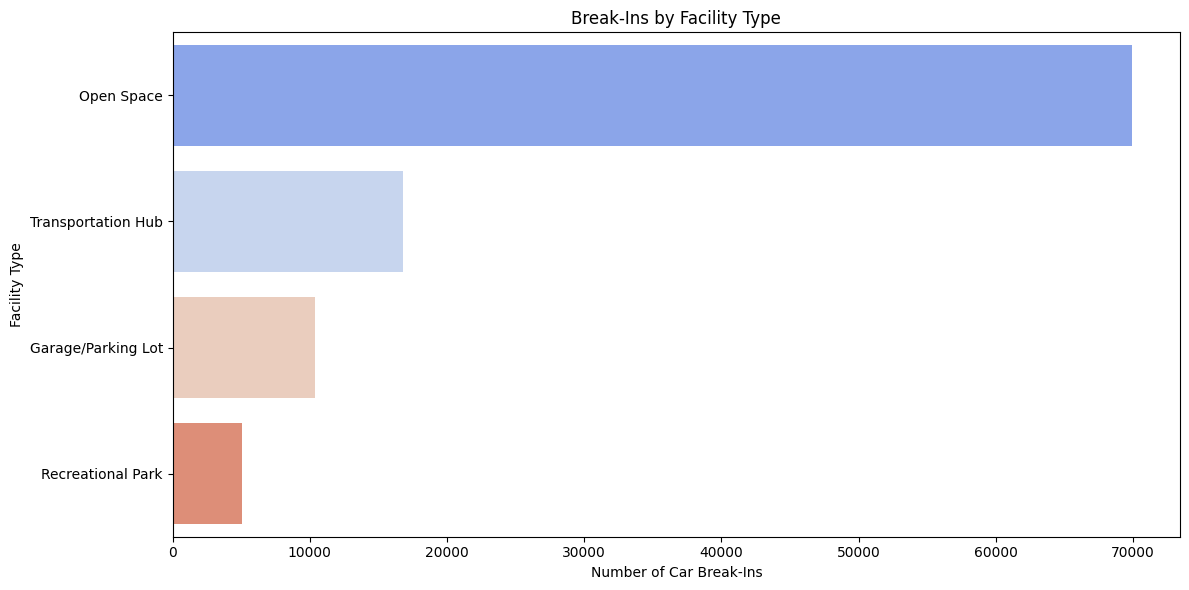

In [53]:
def categorize_facility(name):
    if 'Garage' in name or 'Parking' in name:
        return 'Garage/Parking Lot'
    elif 'Park' in name or 'Recreation' in name:
        return 'Recreational Park'
    elif 'SFMTA' in name or 'Station' in name or 'Transit' in name or 'Hub' in name:
        return 'Transportation Hub'
    elif 'Square' in name or 'Plaza' in name or 'Open' in name or 'Beach':
        return 'Open Space'
    else:
        return 'Other'
cs5834_car_breakins['Facility Type'] = cs5834_car_breakins['common_name'].apply(categorize_facility)
facility_type_counts = cs5834_car_breakins.groupby('Facility Type')['Incident Description'].count().reset_index(name='Break-In Count')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=facility_type_counts.sort_values(by='Break-In Count', ascending=False),
    x='Break-In Count',
    y='Facility Type',
    palette='coolwarm'
)
plt.title("Break-Ins by Facility Type")
plt.xlabel("Number of Car Break-Ins")
plt.ylabel("Facility Type")
plt.tight_layout()
plt.show()


### Time Series Forecasting (Monthly)

<ipython-input-54-6bb7a70a6637>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cs5834_monthly_data = cs5834_car_breakins.resample('M', on='Incident Datetime').size()


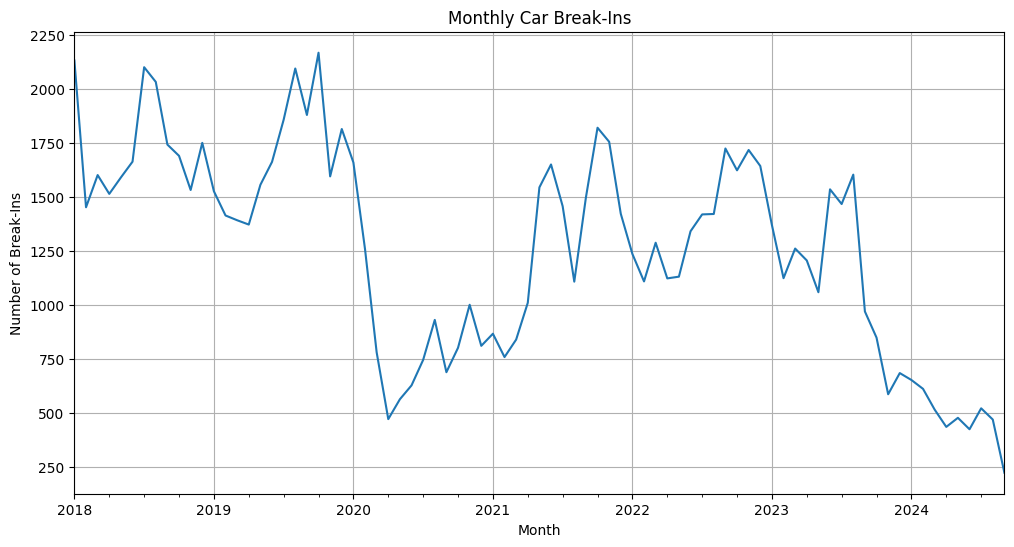

In [54]:
cs5834_car_breakins['Incident Datetime'] = pd.to_datetime(cs5834_car_breakins['Incident Datetime'])
cs5834_monthly_data = cs5834_car_breakins.resample('M', on='Incident Datetime').size()
cs5834_monthly_data = cs5834_monthly_data.rename("Break-In Count").to_frame()
plt.figure(figsize=(12, 6))
cs5834_monthly_data['Break-In Count'].plot()
plt.title("Monthly Car Break-Ins")
plt.xlabel("Month")
plt.ylabel("Number of Break-Ins")
plt.grid(True)
plt.show()


#### Decomposing the Time series

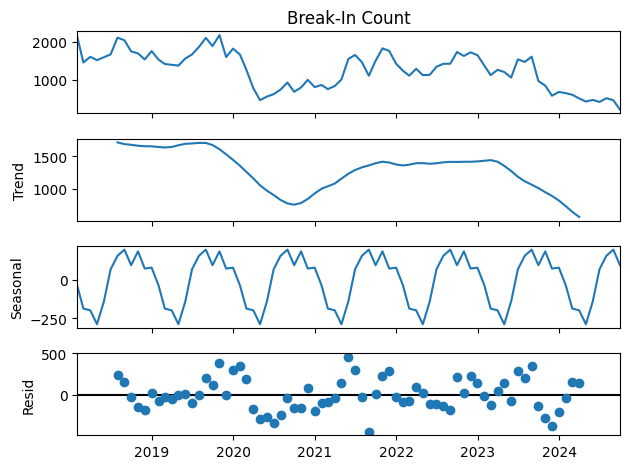

In [55]:
cs5834_decomposition = seasonal_decompose(cs5834_monthly_data['Break-In Count'], model='additive')
cs5834_decomposition.plot()
plt.show()

#### Performing Stationarity Test and Differencing

In [56]:
cs5834_adf_test = adfuller(cs5834_monthly_data['Break-In Count'])
print(f"ADF Statistic: {cs5834_adf_test[0]}")
print(f"p-value: {cs5834_adf_test[1]}")
if cs5834_adf_test[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -2.105570719157115
p-value: 0.24228049558507225
The time series is not stationary.


ADF Statistic (Differenced): -9.322476224464614
p-value (Differenced): 9.80802150667151e-16


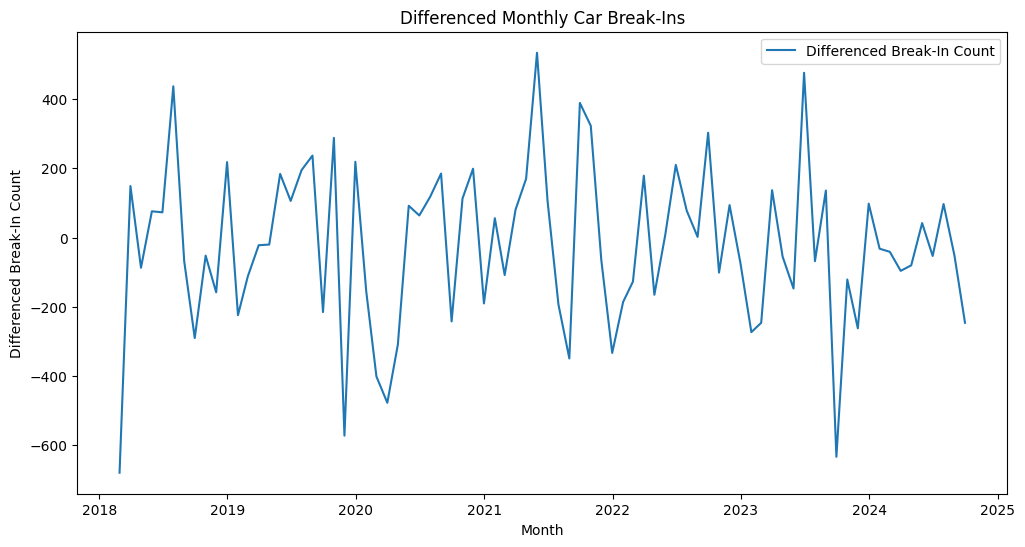

In [57]:
cs5834_monthly_breakins_diff = cs5834_monthly_data.diff().dropna()
cs5834_result_diff = adfuller(cs5834_monthly_breakins_diff['Break-In Count'])
print("ADF Statistic (Differenced):", cs5834_result_diff[0])
print("p-value (Differenced):", cs5834_result_diff[1])
plt.figure(figsize=(12, 6))
plt.plot(cs5834_monthly_breakins_diff.index, cs5834_monthly_breakins_diff['Break-In Count'], label='Differenced Break-In Count')
plt.title("Differenced Monthly Car Break-Ins")
plt.xlabel("Month")
plt.ylabel("Differenced Break-In Count")
plt.legend()
plt.show()

#### ETS Model for Time Series

ETS Model Evaluation Metrics:
RMSE: 223.45
MAPE: 166.60%


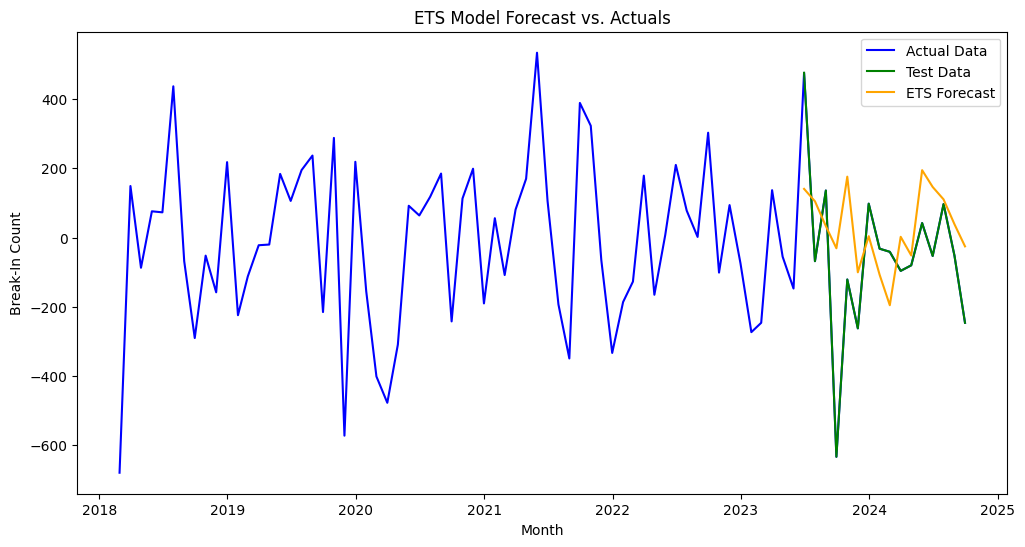

In [58]:
train_size = int(len(cs5834_monthly_breakins_diff) * 0.8)
cs5834_train_data = cs5834_monthly_breakins_diff['Break-In Count'][:train_size]
cs5834_test_data = cs5834_monthly_breakins_diff['Break-In Count'][train_size:]
cs5834_ets_model = ExponentialSmoothing(cs5834_train_data, seasonal='add', trend='add', seasonal_periods=12)
cs5834_ets_fit = cs5834_ets_model.fit()
cs5834_ets_forecast = cs5834_ets_fit.forecast(steps=len(cs5834_test_data))

cs5834_rmse = np.sqrt(mean_squared_error(cs5834_test_data, cs5834_ets_forecast))
cs5834_mape = mean_absolute_percentage_error(cs5834_test_data, cs5834_ets_forecast)

print(f"ETS Model Evaluation Metrics:")
print(f"RMSE: {cs5834_rmse:.2f}")
print(f"MAPE: {cs5834_mape:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(cs5834_monthly_breakins_diff.index, cs5834_monthly_breakins_diff['Break-In Count'], label='Actual Data', color='blue')
plt.plot(cs5834_test_data.index, cs5834_test_data, label='Test Data', color='green')
plt.plot(cs5834_test_data.index, cs5834_ets_forecast, label='ETS Forecast', color='orange')
plt.title("ETS Model Forecast vs. Actuals")
plt.xlabel("Month")
plt.ylabel("Break-In Count")
plt.legend()
plt.show()


### ARIMA Model

#### Plotting the ACF and PACF  Plots To Get P, D, Q params

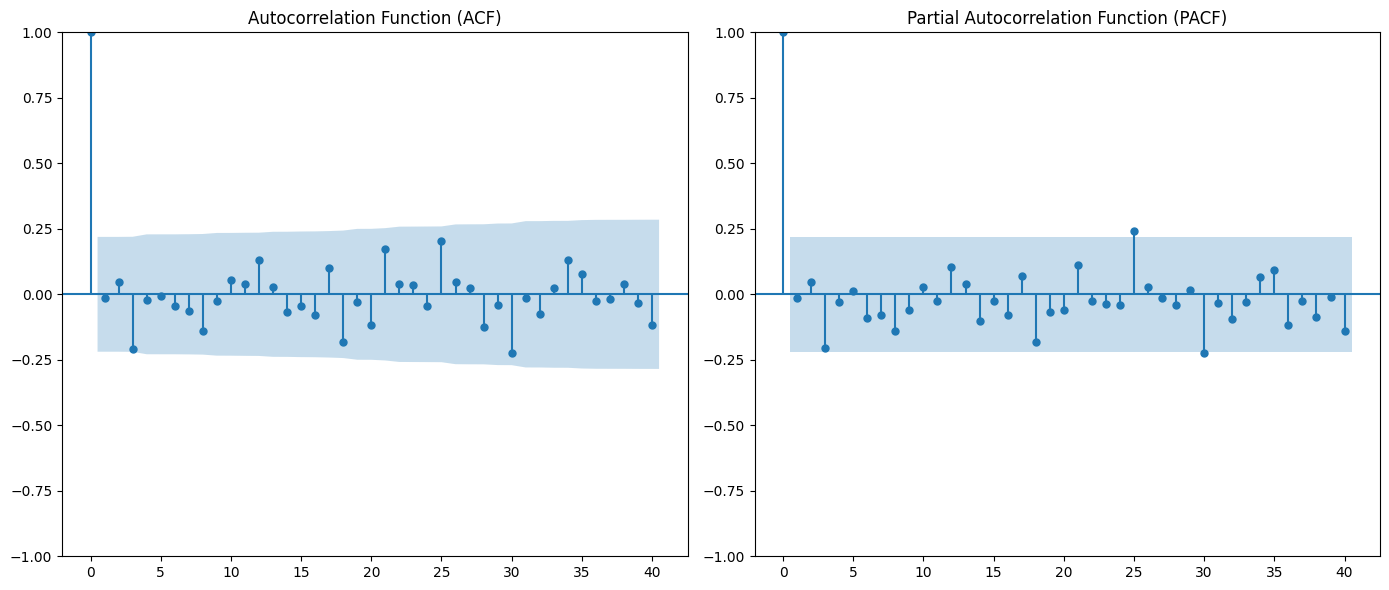

In [59]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(cs5834_monthly_breakins_diff['Break-In Count'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(cs5834_monthly_breakins_diff['Break-In Count'], lags=40, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:         Break-In Count   No. Observations:                   80
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -552.524
Date:                Sat, 14 Dec 2024   AIC                           1111.048
Time:                        00:59:32   BIC                           1118.118
Sample:                    02-28-2018   HQIC                          1113.878
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5200      0.098     -5.311      0.000      -0.712      -0.328
ma.L1         -0.9997     10.296     -0.097      0.923     -21.179      19.179
sigma2      7.956e+04   8.16e+05      0.098      0.9

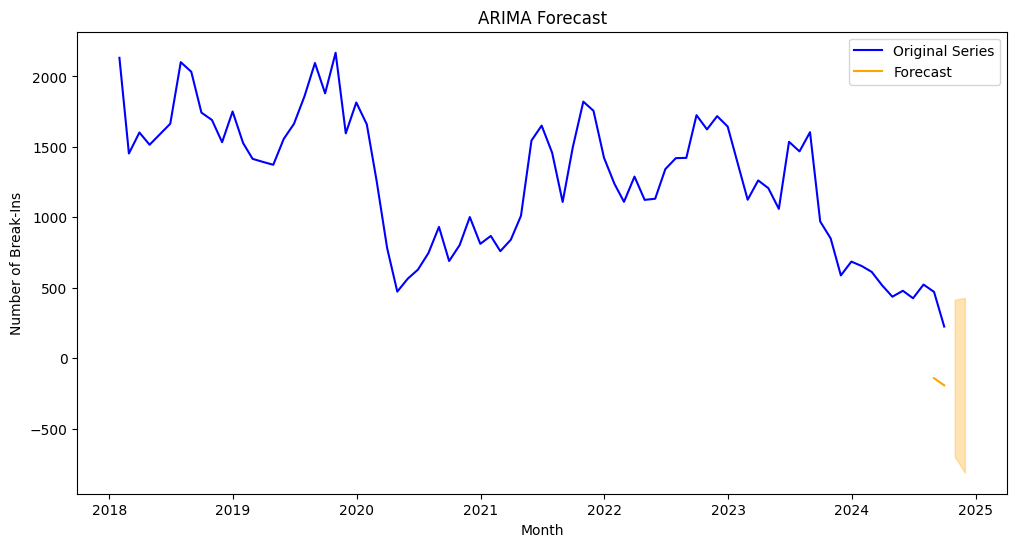

In [60]:
cs5834_model = ARIMA(cs5834_monthly_breakins_diff, order=(1, 2, 1))
cs5834_arima_result = cs5834_model.fit()
print(cs5834_arima_result.summary())
cs5834_forecast_steps = 2  # Forecast for the next 12 months
cs5834_forecast = cs5834_arima_result.get_forecast(steps=cs5834_forecast_steps)
cs5834_forecast_mean = cs5834_forecast.predicted_mean
cs5834_forecast_ci = cs5834_forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(cs5834_monthly_data.index, cs5834_monthly_data, label='Original Series', color='blue')
plt.plot(cs5834_monthly_data.index[-len(cs5834_forecast_mean):], cs5834_forecast_mean, label='Forecast', color='orange')
plt.fill_between(cs5834_forecast_ci.index, cs5834_forecast_ci.iloc[:, 0], cs5834_forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Break-Ins')
plt.legend()
plt.show()

In [63]:
cs5834_train_size = int(len(cs5834_monthly_breakins_diff) * 0.8)
cs5834_train, cs5834_test = cs5834_monthly_breakins_diff[:cs5834_train_size], cs5834_monthly_breakins_diff[cs5834_train_size:]

cs5834_model_train = ARIMA(cs5834_train, order=(1, 1, 1))
cs5834_result_train = cs5834_model_train.fit()
cs5834_forecast_test = cs5834_result_train.forecast(steps=len(cs5834_test))
cs5834_rmse = np.sqrt(mean_squared_error(cs5834_test, cs5834_forecast_test))
cs5834_mape = mean_absolute_percentage_error(cs5834_test, cs5834_forecast_test) * 100

print(f"ARIMA Model Evaluation Metrics:\nRMSE: {cs5834_rmse:.2f}\nMAPE: {cs5834_mape:.2f}%")


ARIMA Model Evaluation Metrics:
RMSE: 226.35
MAPE: 89.80%


### Finding Optimal Params (p,d,q and P,D,Q) for SARIMA

In [ ]:
def cs5834_sarima_forecast(history, config):
    order, sorder, trend = config
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=sorder,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def cs5834_measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def cs5834_train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def cs5834_walk_forward_validation(data, n_test, cfg):
    predictions = []
    train, test = cs5834_train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = cs5834_sarima_forecast(history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = cs5834_measure_rmse(test, predictions)
    return error

def cs5834_score_model(data, n_test, cfg, debug=False):
    result = None
    key = str(cfg)
    try:
        with catch_warnings():
            filterwarnings("ignore")
            result = cs5834_walk_forward_validation(data, n_test, cfg)
    except:
        pass
    if result is not None:
        print(f" > Model[{key}] RMSE: {result:.3f}")
    return (key, result)

def cs5834_grid_search(data, cfg_list, n_test, parallel=True):
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(cs5834_score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [cs5834_score_model(data, n_test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] is not None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def cs5834_sarima_configs(seasonal=[0]):
    models = []
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    models.append(cfg)
    return models

if __name__ == '__main__':
    data = cs5834_monthly_breakins_diff.values.flatten()
    print(f"Dataset Length: {len(data)}")
    seasonal_period = [12]
    n_test = 12
    cfg_list = cs5834_sarima_configs(seasonal=seasonal_period)
    print("Starting SARIMA grid search...")
    scores = cs5834_grid_search(data, cfg_list, n_test)
    print("Grid search completed.")
    print("\nTop 3 SARIMA Configurations:")
    for cfg, error in scores[:3]:
        print(f"Config: {cfg}, RMSE: {error:.3f}")


Dataset Length: 80
Starting SARIMA grid search...
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 119.661
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 120.646
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 259.165
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 134.241
 > Model[[(0, 0, 0), (0, 0, 2, 12), 'n']] 26051302.073
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 118.349
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 121.017
 > Model[[(0, 0, 0), (0, 1, 2, 12), 'n']] 156.614
 > Model[[(0, 0, 0), (1, 1, 0, 12), 'n']] 208.368
 > Model[[(0, 0, 0), (1, 1, 1, 12), 'n']] 136.238
 > Model[[(0, 0, 0), (1, 0, 2, 12), 'n']] 306709.391
 > Model[[(0, 0, 0), (2, 0, 0, 12), 'n']] 117.857
 > Model[[(0, 0, 0), (2, 0, 1, 12), 'n']] 120.023
 > Model[[(0, 0, 0), (1, 1, 2, 12), 'n']] 150.514
 > Model[[(0, 0, 0), (2, 1, 0, 12), 'n']] 202.246
 > Model[[(0, 0, 0), (2, 0, 2, 12), 'n']] 194.708
 > Model[[(0, 0, 0), (2, 1, 1, 12), 'n']] 140.493
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'c']] 115.263
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'c']] 

### SARIMA Model after Grid Search of P,D,Q params

SARIMAX Model Evaluation Metrics:
RMSE: 234.19
MAPE: 82.04%


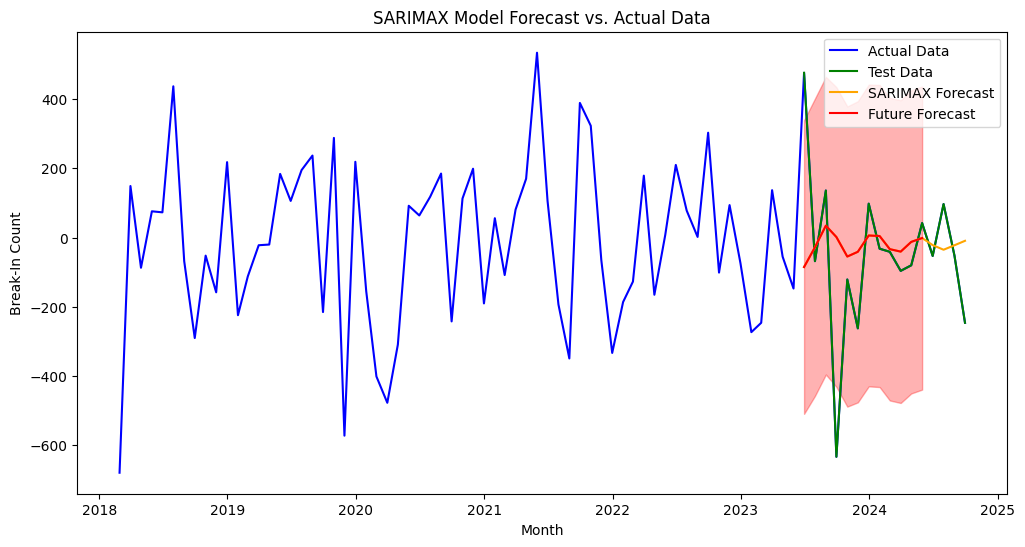

In [67]:
train_size = int(len(cs5834_monthly_breakins_diff) * 0.8)
train_data = cs5834_monthly_breakins_diff['Break-In Count'][:train_size]
test_data = cs5834_monthly_breakins_diff['Break-In Count'][train_size:]

sarimax_model = SARIMAX(
    train_data,
    order=(2, 0, 2),
    seasonal_order=(0, 0, 0, 12),
    trend='t',
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax_model.fit(disp=False)
sarimax_forecast = sarimax_fit.forecast(steps=len(test_data))
rmse = np.sqrt(mean_squared_error(test_data, sarimax_forecast))
mape = mean_absolute_percentage_error(test_data, sarimax_forecast) * 100

print(f"SARIMAX Model Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

forecast_steps = 12
sarimax_future_forecast = sarimax_fit.get_forecast(steps=forecast_steps)
forecast_mean = sarimax_future_forecast.predicted_mean
forecast_ci = sarimax_future_forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(cs5834_monthly_breakins_diff.index, cs5834_monthly_breakins_diff['Break-In Count'], label='Actual Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='green')
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Forecast', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Future Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.title("SARIMAX Model Forecast vs. Actual Data")
plt.xlabel("Month")
plt.ylabel("Break-In Count")
plt.legend()
plt.show()

### Random Forest Algorithm

In [69]:
def cs5834_create_lagged_features(data, n_lags):
    df = pd.DataFrame(data)
    df.columns = ['value']
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['value'].shift(lag)
    df['month'] = data.index.month
    df['year'] = data.index.year
    return df.dropna()

In [70]:
cs5834_n_lags = 12
cs5834_lagged_data = cs5834_create_lagged_features(cs5834_monthly_breakins_diff, cs5834_n_lags)
cs5834_lagged_data['target'] = cs5834_monthly_breakins_diff.values[cs5834_n_lags:]
cs5834_lagged_data.index = cs5834_monthly_breakins_diff.index[cs5834_n_lags:]
cs5834_train_data = cs5834_lagged_data[cs5834_lagged_data.index <= "2024-03-31"]
cs5834_test_data = cs5834_lagged_data[
    (cs5834_lagged_data.index > "2024-03-31") & (cs5834_lagged_data.index <= "2024-09-30")
]

cs5834_X_train = cs5834_train_data.drop('target', axis=1)
cs5834_y_train = cs5834_train_data['target']
cs5834_X_test = cs5834_test_data.drop('target', axis=1)
cs5834_y_test = cs5834_test_data['target']
cs5834_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
cs5834_rf_model.fit(cs5834_X_train, cs5834_y_train)

RandomForestRegressor(random_state=42)

In [71]:
cs5834_y_pred = cs5834_rf_model.predict(cs5834_X_test)
cs5834_rmse = np.sqrt(mean_squared_error(cs5834_y_test, cs5834_y_pred))
cs5834_mape = mean_absolute_percentage_error(cs5834_y_test, cs5834_y_pred) * 100
print(f"Random Forest Model Test Evaluation Metrics:\nRMSE: {cs5834_rmse:.2f}\nMAPE: {cs5834_mape:.2f}%")

Random Forest Model Test Evaluation Metrics:
RMSE: 11.61
MAPE: 15.08%


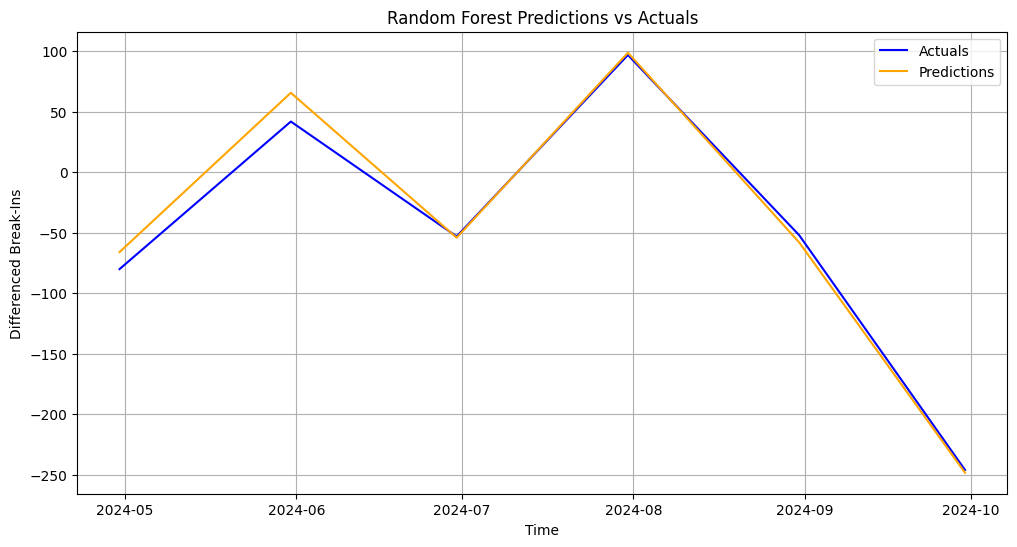

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(cs5834_test_data.index, cs5834_y_test, label='Actuals', color='blue')
plt.plot(cs5834_test_data.index, cs5834_y_pred, label='Predictions', color='orange')
plt.title('Random Forest Predictions vs Actuals')
plt.xlabel('Time')
plt.ylabel('Differenced Break-Ins')
plt.grid(True)
plt.legend()
plt.show()

In [81]:
def cs5834_forecast_future(model, data, n_forecast):
    forecast = []
    current_data = data.copy()
    for _ in range(n_forecast):
        pred = model.predict([current_data.iloc[-1].values])[0]
        forecast.append(pred)
        new_row = pd.Series(
            [pred] + current_data.iloc[-1, :-1].tolist(),
            index=current_data.columns
        )
        current_data = pd.concat([current_data, new_row.to_frame().T], ignore_index=True)
    return forecast
cs5834_future_forecast = cs5834_forecast_future(cs5834_rf_model, cs5834_X_test, 2)  # Forecast for October and November 2024
print(f"Forecast for Future Months:\n{cs5834_future_forecast}")

Forecast for Future Months:
[-246.36, -255.34]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<ipython-input-82-bfd0468211cd>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cs5834_future_dates = pd.date_range(start=cs5834_test_data.index[-1], periods=3, freq='M')[1:]


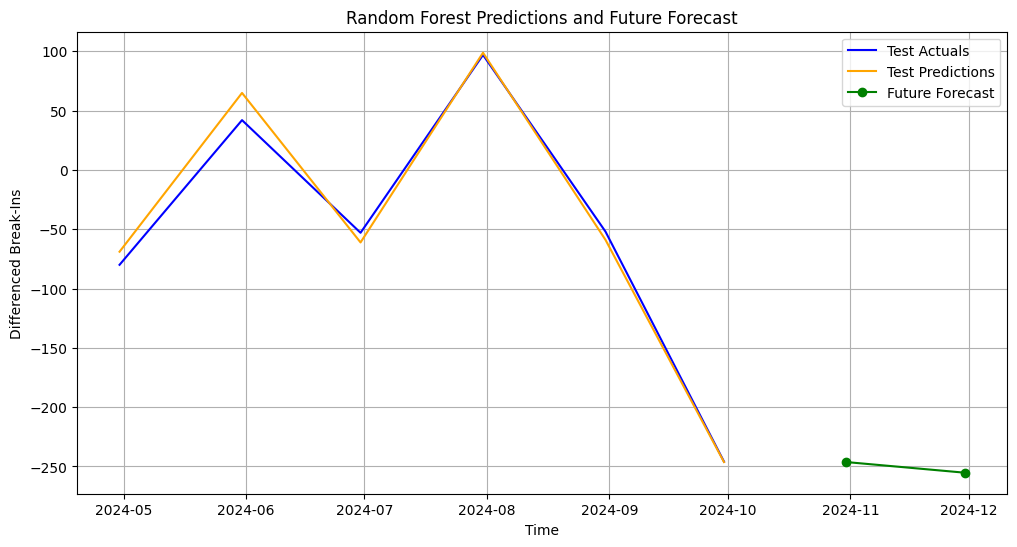

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(cs5834_test_data.index, cs5834_y_test, label='Test Actuals', color='blue')
plt.plot(cs5834_test_data.index, cs5834_y_pred, label='Test Predictions', color='orange')
cs5834_future_dates = pd.date_range(start=cs5834_test_data.index[-1], periods=3, freq='M')[1:]
plt.plot(cs5834_future_dates, cs5834_future_forecast, label='Future Forecast', color='green', marker='o')
plt.title('Random Forest Predictions and Future Forecast')
plt.xlabel('Time')
plt.ylabel('Differenced Break-Ins')
plt.grid(True)
plt.legend()
plt.show()

#### Ensemble models - XGBoost

In [75]:
def cs5834_create_lagged_features(data, n_lags):
    df = pd.DataFrame(data)
    df.columns = ['value']
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['value'].shift(lag)
    df['month'] = data.index.month
    df['year'] = data.index.year
    return df.dropna()
cs5834_n_lags = 12
cs5834_lagged_data = cs5834_create_lagged_features(cs5834_monthly_breakins_diff, cs5834_n_lags)
cs5834_lagged_data['target'] = cs5834_monthly_breakins_diff.values[cs5834_n_lags:]
cs5834_lagged_data.index = cs5834_monthly_breakins_diff.index[cs5834_n_lags:]

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [76]:
cs5834_train_size = int(len(cs5834_lagged_data) * 0.8)
cs5834_train, cs5834_test = cs5834_lagged_data.iloc[:cs5834_train_size], cs5834_lagged_data.iloc[cs5834_train_size:]

cs5834_X_train = cs5834_train.drop('target', axis=1)
cs5834_y_train = cs5834_train['target']
cs5834_X_test = cs5834_test.drop('target', axis=1)
cs5834_y_test = cs5834_test['target']
cs5834_xgb_model = XGBRegressor(n_estimators=100, booster='gbtree', random_state=5834)
print("Training XGBoost model...")
cs5834_xgb_model.fit(cs5834_X_train, cs5834_y_train)

Training XGBoost model...


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=5834, ...)

In [77]:
cs5834_y_pred = cs5834_xgb_model.predict(cs5834_X_test)
cs5834_rmse = np.sqrt(mean_squared_error(cs5834_y_test, cs5834_y_pred))
cs5834_mape = mean_absolute_percentage_error(cs5834_y_test, cs5834_y_pred) * 100
print(f"XGBoost Model Evaluation Metrics:\nRMSE: {cs5834_rmse:.2f}\nMAPE: {cs5834_mape:.2f}%")

XGBoost Model Evaluation Metrics:
RMSE: 22.46
MAPE: 20.15%


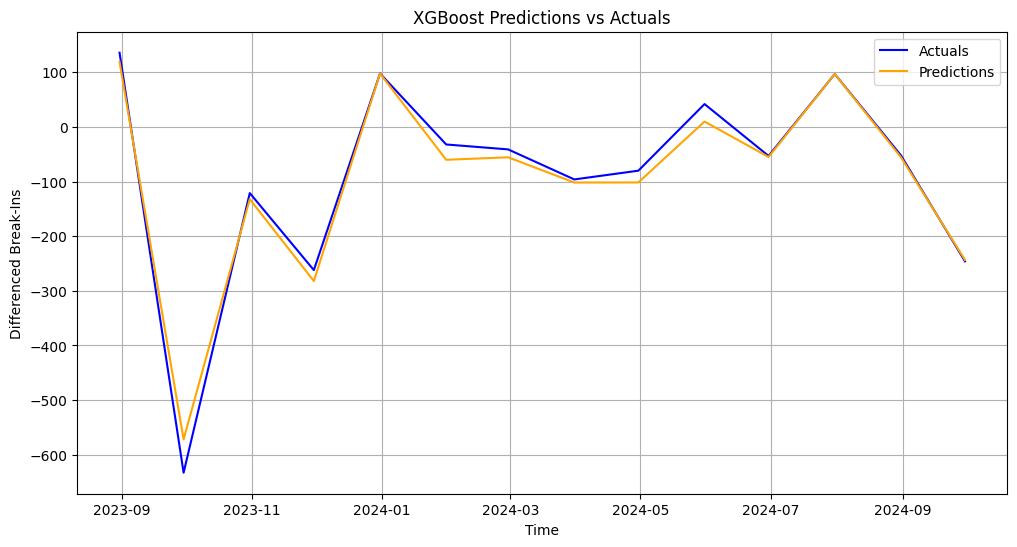

Forecast for Future Months:
[-243.50368, -241.72527]


<ipython-input-78-84696d227590>:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=cs5834_test.index[-1], periods=3, freq='M')[1:]


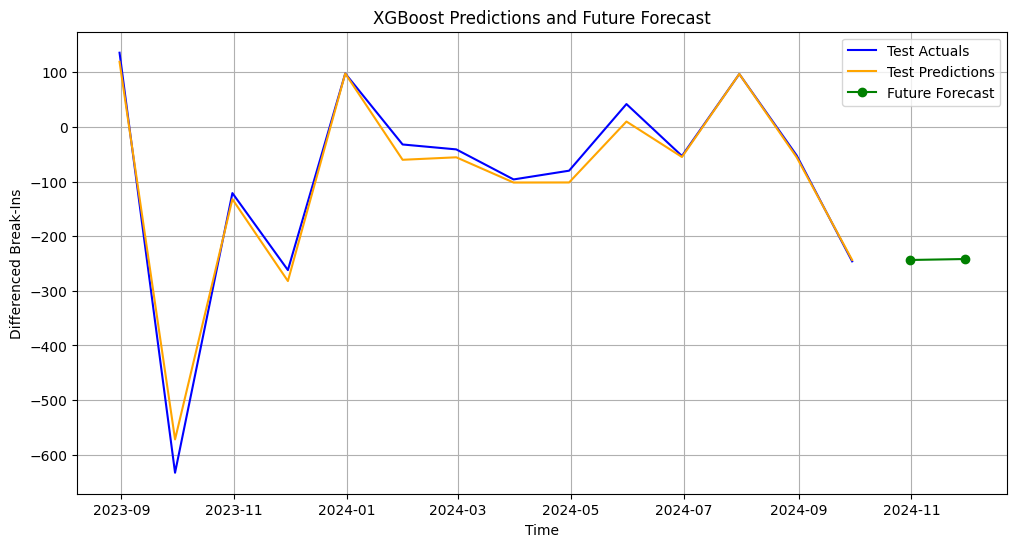

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(cs5834_test.index, cs5834_y_test, label='Actuals', color='blue')
plt.plot(cs5834_test.index, cs5834_y_pred, label='Predictions', color='orange')
plt.title('XGBoost Predictions vs Actuals')
plt.xlabel('Time')
plt.ylabel('Differenced Break-Ins')
plt.grid(True)
plt.legend()
plt.show()

def cs5834_forecast_future(model, data, n_forecast):
    forecast = []
    current_data = data.copy()
    for _ in range(n_forecast):
        # Predict the next value
        pred = model.predict([current_data.iloc[-1].values])[0]
        forecast.append(pred)

        # Update the dataset with the predicted value
        new_row = pd.Series([pred] + current_data.iloc[-1, :-1].tolist(), index=current_data.columns)
        current_data = pd.concat([current_data, new_row.to_frame().T], ignore_index=True)
    return forecast

cs5834_future_forecast = cs5834_forecast_future(cs5834_xgb_model, cs5834_X_test, 2)  # Forecast for October and November 2024
print(f"Forecast for Future Months:\n{cs5834_future_forecast}")
plt.figure(figsize=(12, 6))
plt.plot(cs5834_test.index, cs5834_y_test, label='Test Actuals', color='blue')
plt.plot(cs5834_test.index, cs5834_y_pred, label='Test Predictions', color='orange')
future_dates = pd.date_range(start=cs5834_test.index[-1], periods=3, freq='M')[1:]
plt.plot(future_dates, cs5834_future_forecast, label='Future Forecast', color='green', marker='o')
plt.title('XGBoost Predictions and Future Forecast')
plt.xlabel('Time')
plt.ylabel('Differenced Break-Ins')
plt.grid(True)
plt.legend()
plt.show()